# Test network model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from logger import logger
from networkmodel import *
from utils import *

# Initialize empty figures dictionary
figs = {}

## Literature review

### Network connectivity matrices

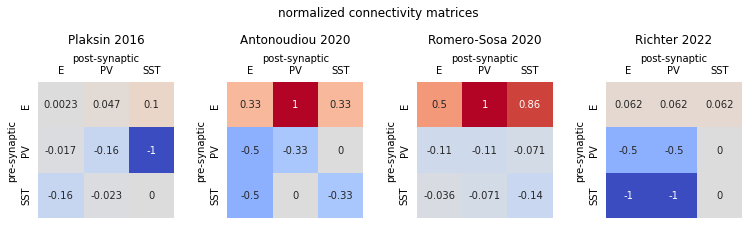

In [3]:
# Population names
populations = ['E', 'PV', 'SST']

# Connectivity matrix (from Plaksin et al. 2016)
W_plaksin = pd.DataFrame(
    data=[
        [0.002, 0.04, 0.09],      # E -> E, PV, SST 
        [-0.015, -0.135, -0.86],  # PV -> E, PV, SST
        [-0.135, -0.02, 0]        # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Antonoudiou et al. 2020)
W_antonoudiou = pd.DataFrame(
    data=[
        [10, 30, 10],   # E -> E, PV, SST 
        [-15, -10, 0],  # PV -> E, PV, SST
        [-15, 0, -10]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Romero-Sosa et al. 2020, Figure 6A,B)
W_romero_sosa = pd.DataFrame(
    data=[
        [7, 14, 12],   # E -> E, PV, SST 
        [-1.5, -1.5, -1],  # PV -> E, PV, SST
        [-0.5, -1, -2]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Connectivity matrix (from Richter et al. 2022)
W_richter = pd.DataFrame(
    data=[
        [0.1, 0.1, 0.1],   # E -> E, PV, SST 
        [-0.8, -0.8, 0],  # PV -> E, PV, SST
        [-1.6, -1.6, 0]   # SST -> E, PV, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Comparative plot of connectivity matrices
Wdict = {
    'Plaksin 2016': W_plaksin,
    'Antonoudiou 2020': W_antonoudiou,
    'Romero-Sosa 2020': W_romero_sosa,
    'Richter 2022': W_richter    
}
figs['connectivity comparisons'] = NetworkModel.plot_connectivity_matrix(Wdict, norm=True)

### Firing rate adaptation time constants

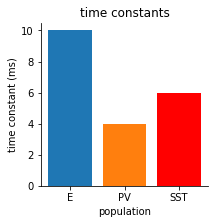

In [4]:
# Time constants (from Romero-Sosa et al. 2020)
tau = pd.Series(
    data={
        'E': 0.010, 
        'PV': .004, 
        'SST': .006
    },
    name='tau (s)'
)

figs['time constants'] = NetworkModel(tau=tau).plot_time_constants()

### Gain functions

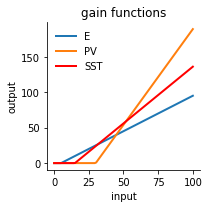

In [5]:
# Gain functions from Romero-Sosa et al. 2020
fgain = threshold_linear
fgain_params = pd.DataFrame(
    data={
        'x0': [5, 30, 15],  # E, PV, SST
        'A': [1, 2.7, 1.6], # E, PV, SST
    },
    index=pd.Index(populations, name='population'),
)

figs['fgain'] = NetworkModel(fgain=fgain, fgain_params=fgain_params).plot_fgain()

## 2-population (E, SST) model 

### Define model

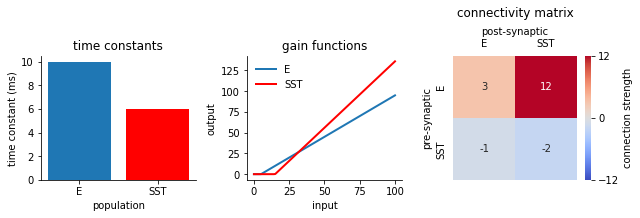

In [6]:
# Time constants (from Romero-Sosa et al. 2020)
tau = pd.Series(
    data={
        'E': 0.010, 
        'SST': .006
    },
    name='tau (s)'
)
populations = tau.index

# Gain function
fgain = threshold_linear

# Gain function parameters (from Romero-Sosa et al. 2020)
fgain_params = pd.DataFrame(
    data={
        'x0': [
            5,  # E 
            15  # SST
        ],
        'A': [
            1,  # E  
            1.6  # SST
        ],
    },
    index=pd.Index(populations, name='population'),
)

# Connectivity matrix
W = pd.DataFrame(
    data=[
        [3, 12],   # E -> E, SST
        [-1, -2]   # SST -> E, SST
    ], 
    index=pd.Index(populations, name='pre-synaptic'), 
    columns=pd.Index(populations, name='post-synaptic')
)

# Initialize model
model = NetworkModel(W=W, tau=tau, fgain=fgain, fgain_params=fgain_params)

# Check balance of excitation vs inhibition
We = model.get_net_excitation('SST')
Wi = model.get_net_inhibition('SST')
if Wi < We:
    raise ValueError(f'net inhibition strength {Wi} < net excitation strength ({We})')

# Plot model summary
figs['2-pop model'] = model.plot_summary()

### Example simulation and stimulus amplitude sweep

 2024/03/12 18:58:27: external input:
E      6.0
SST    6.0
Name: external input, dtype: float64
 2024/03/12 18:58:27: NetworkModel([E, SST]): running 0.5 s long simulation
 2024/03/12 18:58:27: simulation completed in 0.023 s


 2024/03/12 18:58:28: running stimulation sweep


100%|██████████| 50/50 [00:01<00:00, 37.83it/s]


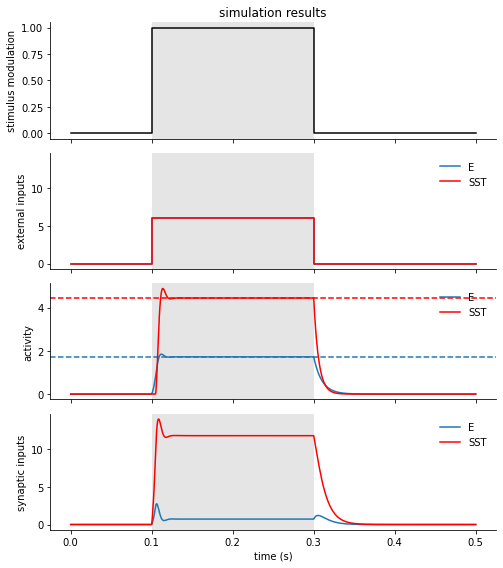

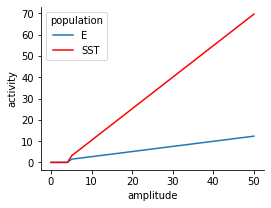

In [7]:
# External input
Ithr = fgain_params.loc['E', 'x0']  # E activation threshold
srel = pd.Series(1., index=model.keys, name='external input')  # relative input strength
s = 1.2 * Ithr * srel
logger.info(f'external input:\n{s}')

# Simulate model, and extract steady-state stimulus-evoked activity
data = model.simulate(s=s)
rss = model.extract_steady_state(data)

# Plot results
figs['2-pop timeseries'] = model.plot_timeseries(data, ss=rss, add_synaptic_drive=True)

# Define vector of amplitudes of external input w.r.t. reference value
rel_amps = np.linspace(0, 10, 50)
amps = rel_amps * Ithr

# Simulate model for each amplitude
sweep_data = model.run_stim_sweep(srel, amps)

# Extract steady-state stimulus-evoked activity for each relative amplitude
sweep_rss = model.extract_steady_state(sweep_data)
# Plot steady-state activity dependency on stimulus amplitude
figs['2-pop ss dep norm.'] = model.plot_sweep_results(sweep_rss)

### Amplitude dependency profiles for various changes in network connectivity

In [8]:
# # Initialize empty dictionary of sweep results
# sweep_res_dict = {}

# # Vary global coupling strength
# Wscale = np.linspace(0, 10, 5)
# sweep_res_dict['Wscale'] = model.run_W_sweep(Wscale, srel, amps, pre_key=None, post_key=None)

# # For each pair of populations, vary the coupling strength
# for prekey in model.keys:
#     for postkey in model.keys:
#         key = f'W{prekey}-{postkey}'
#         Wthr = model.get_critical_value(prekey, postkey)
#         if prekey == postkey:
#             Wvec = Wthr * np.linspace(0, .9, 5)
#         else:
#             Wvec = Wthr * np.linspace(1.1, 5, 5)
#         Wvec = np.sort(Wvec)
#         sweep_res_dict[key] = model.run_W_sweep(Wvec, srel, amps, pre_key=prekey, post_key=postkey)

# # Plot results of each sweep
# norm = False
# for key, sweep_res in sweep_res_dict.items():
#     figs[f'2-pop {key} sweep'] = model.plot_sweep_results(sweep_res, norm=norm)

### Reference population-specific activation profiles 

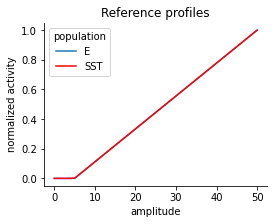

In [9]:
ref_profiles = pd.DataFrame(
    data={
        'E': threshold_linear(amps, **fgain_params.loc['E', :]),
        'SST': threshold_linear(amps, **fgain_params.loc['E', :])
    },
    index=pd.Index(amps, name='amplitude')
)
ref_profiles.columns.name = 'population'
figs['2-pop ref profiles'] = model.plot_sweep_results(ref_profiles, norm=True)
figs['2-pop ref profiles'].axes[0].set_title('Reference profiles');

### Exploration / optimization

In [12]:
# cost = model.explore(ref_profiles, srel, norm=True)
Wopt = model.optimize(ref_profiles, srel, norm=True)

 2024/03/12 18:59:30: running optimization algorithm
 2024/03/12 18:59:31: simulation divergence detected


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__use

 2024/03/12 18:59:32: simulation divergence detected
 2024/03/12 18:59:32: simulation divergence detected


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__use

 2024/03/12 18:59:34: unstable final steady-states detected
 2024/03/12 18:59:37: unstable stimulus-evoked steady-states detected
 2024/03/12 18:59:37: simulation divergence detected
 2024/03/12 18:59:37: simulation divergence detected


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__use

 2024/03/12 18:59:39: unstable stimulus-evoked steady-states detected


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__use

 2024/03/12 18:59:41: non-zero final steady-states detected
 2024/03/12 18:59:41: simulation divergence detected


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__use

 2024/03/12 18:59:44: unstable stimulus-evoked steady-states detected
 2024/03/12 18:59:46: unstable final steady-states detected


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__use

 2024/03/12 18:59:47: simulation divergence detected
 2024/03/12 18:59:47: simulation divergence detected


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__use

KeyboardInterrupt: 

## 3-population (E, SST, PV) model

### Define model

 2024/03/12 17:12:57: E-PV loop strengh = 21.0, E-SST loop strength = 6.0


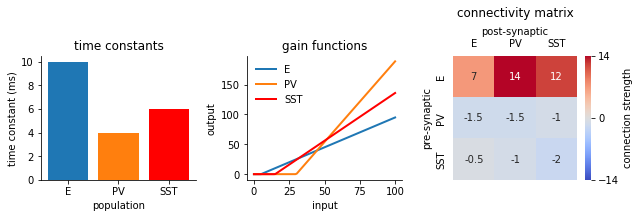

In [40]:
# Populations
populations = ['E', 'PV', 'SST']

# Time constants (from Romero-Sosa et al. 2020)
tau = pd.Series(
    data={
        'E': 0.010, 
        'PV': .004, 
        'SST': .006
    },
    name='tau (s)'
)

# Gain function
fgain = threshold_linear

# Gain function parameters (from Romero-Sosa et al. 2020)
fgain_params = pd.DataFrame(
    data={
        'x0': [5, 30, 15],  # E, PV, SST
        'A': [1, 2.7, 1.6], # E, PV, SST
    },
    index=pd.Index(populations, name='population'),
)

# Connectivity matrix (from Romero-Sosa et al. 2020)
W = Wdict['Romero-Sosa 2020']

# Initialize model
model = NetworkModel(W=W, tau=tau, fgain=fgain, fgain_params=fgain_params)

# Check balance of E-PV vs E-SST loops
E_PV = model.get_net_inhibition('PV')
E_SST = model.get_net_inhibition('SST')
if E_PV < E_SST:
    logger.warning(f'E-PV loop strengh ({E_PV}) < E-SST loop strength ({E_SST})')
else:
    logger.info(f'E-PV loop strengh = {E_PV}, E-SST loop strength = {E_SST}')

# Plot model summary
figs['3-pop model'] = model.plot_summary()

### Example simulation and stimulus amplitude sweep

 2024/03/12 17:12:59: external input:
E      6.0
PV     6.0
SST    6.0
Name: external input, dtype: float64
 2024/03/12 17:12:59: NetworkModel([E, PV, SST]): running 0.5 s long simulation
 2024/03/12 17:12:59: simulation completed in 0.052 s
 2024/03/12 17:12:59: running stimulation sweep


100%|██████████| 50/50 [00:02<00:00, 20.57it/s]


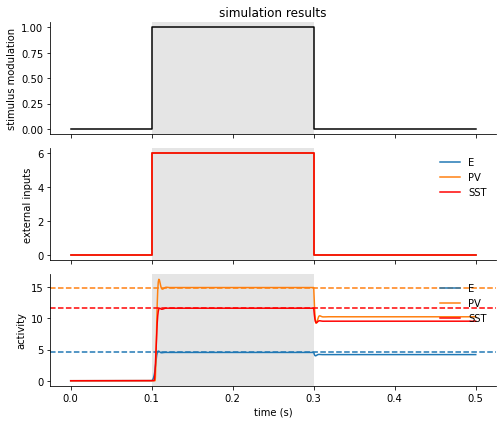

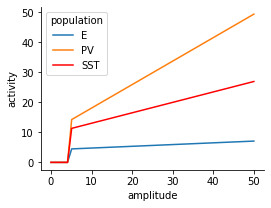

In [41]:
# External input
Ithr = fgain_params.loc['E', 'x0']  # E activation threshold
srel = pd.Series(1., index=model.keys, name='external input')  # relative input strength
s = 1.2 * Ithr * srel
logger.info(f'external input:\n{s}')

# Simulate model, and extract steady-state stimulus-evoked activity
data = model.simulate(s=s)
rss = model.extract_steady_state(data)

# Plot results
figs['3-pop timeseries'] = model.plot_timeseries(data, ss=rss)

# Define vector of amplitudes of external input w.r.t. reference value
rel_amps = np.linspace(0, 10, 50)
amps = rel_amps * Ithr

# Simulate model for each amplitude
sweep_data = model.run_stim_sweep(srel, amps)
# Extract steady-state stimulus-evoked activity for each relative amplitude
sweep_rss = model.extract_steady_state(sweep_data)
# Plot steady-state activity dependency on stimulus amplitude
figs['3-pop ss dep norm.'] = model.plot_sweep_results(sweep_rss)

## Model exploration / optimization

### Reference population-specific activation profiles 

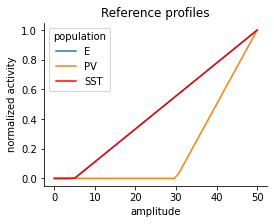

In [42]:
ref_profiles = pd.DataFrame(
    data={
        'E': threshold_linear(amps, **fgain_params.loc['E', :]),
        'PV': threshold_linear(amps, **fgain_params.loc['PV', :]),
        'SST': threshold_linear(amps, **fgain_params.loc['E', :])
    },
    index=pd.Index(amps, name='amplitude')
)
ref_profiles.columns.name = 'population'
figs['ref profiles'] = model.plot_sweep_results(ref_profiles, norm=True)
figs['ref profiles'].axes[0].set_title('Reference profiles');

### Explore

In [65]:
cost = model.explore(ref_profiles, srel, npersweep=2, norm=True)

 2024/03/12 18:04:08: deriving exploration values
 2024/03/12 18:04:08: assembling exploration queue
 2024/03/12 18:04:08: running 512 evaluations exploration
 2024/03/12 18:04:08: evaluation 1/512


100%|██████████| 50/50 [00:01<00:00, 34.15it/s]

 2024/03/12 18:04:10: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:10: evaluation 2/512


100%|██████████| 50/50 [00:01<00:00, 35.75it/s]

 2024/03/12 18:04:12: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:12: evaluation 3/512


100%|██████████| 50/50 [00:01<00:00, 36.37it/s]

 2024/03/12 18:04:13: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:13: evaluation 4/512


100%|██████████| 50/50 [00:01<00:00, 36.58it/s]

 2024/03/12 18:04:15: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:15: evaluation 5/512


100%|██████████| 50/50 [00:01<00:00, 34.07it/s]

 2024/03/12 18:04:17: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:17: evaluation 6/512


100%|██████████| 50/50 [00:01<00:00, 37.73it/s]

 2024/03/12 18:04:19: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:19: evaluation 7/512


100%|██████████| 50/50 [00:01<00:00, 36.14it/s]


 2024/03/12 18:04:20: unstable stimulus-evoked steady-states detected
 2024/03/12 18:04:20: evaluation 8/512


100%|██████████| 50/50 [00:01<00:00, 37.56it/s]

 2024/03/12 18:04:22: unstable final steady-states detected


 2024/03/12 18:04:22: evaluation 9/512


100%|██████████| 50/50 [00:01<00:00, 34.45it/s]


 2024/03/12 18:04:24: unstable stimulus-evoked steady-states detected
 2024/03/12 18:04:24: evaluation 10/512


100%|██████████| 50/50 [00:01<00:00, 35.72it/s]

 2024/03/12 18:04:26: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:26: evaluation 11/512


100%|██████████| 50/50 [00:01<00:00, 35.87it/s]

 2024/03/12 18:04:28: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:28: evaluation 12/512


100%|██████████| 50/50 [00:01<00:00, 36.10it/s]

 2024/03/12 18:04:29: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:29: evaluation 13/512


100%|██████████| 50/50 [00:01<00:00, 34.30it/s]

 2024/03/12 18:04:31: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:31: evaluation 14/512


100%|██████████| 50/50 [00:01<00:00, 37.89it/s]

 2024/03/12 18:04:33: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:33: evaluation 15/512


100%|██████████| 50/50 [00:01<00:00, 35.46it/s]

 2024/03/12 18:04:35: unstable final steady-states detected


 2024/03/12 18:04:35: evaluation 16/512


100%|██████████| 50/50 [00:01<00:00, 37.53it/s]


 2024/03/12 18:04:36: unstable final steady-states detected
 2024/03/12 18:04:36: evaluation 17/512


100%|██████████| 50/50 [00:01<00:00, 35.04it/s]

 2024/03/12 18:04:38: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:38: evaluation 18/512


100%|██████████| 50/50 [00:01<00:00, 35.61it/s]

 2024/03/12 18:04:40: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:40: evaluation 19/512


100%|██████████| 50/50 [00:01<00:00, 36.57it/s]

 2024/03/12 18:04:42: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:42: evaluation 20/512


100%|██████████| 50/50 [00:01<00:00, 37.52it/s]

 2024/03/12 18:04:43: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:43: evaluation 21/512


100%|██████████| 50/50 [00:01<00:00, 34.62it/s]

 2024/03/12 18:04:45: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:45: evaluation 22/512


100%|██████████| 50/50 [00:01<00:00, 37.54it/s]

 2024/03/12 18:04:47: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:47: evaluation 23/512


100%|██████████| 50/50 [00:01<00:00, 36.23it/s]

 2024/03/12 18:04:48: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:48: evaluation 24/512


100%|██████████| 50/50 [00:01<00:00, 37.96it/s]

 2024/03/12 18:04:50: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:50: evaluation 25/512


100%|██████████| 50/50 [00:01<00:00, 33.95it/s]

 2024/03/12 18:04:52: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:52: evaluation 26/512


100%|██████████| 50/50 [00:01<00:00, 36.01it/s]

 2024/03/12 18:04:53: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:53: evaluation 27/512


100%|██████████| 50/50 [00:01<00:00, 34.99it/s]

 2024/03/12 18:04:55: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:55: evaluation 28/512


100%|██████████| 50/50 [00:01<00:00, 36.57it/s]

 2024/03/12 18:04:57: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:57: evaluation 29/512


100%|██████████| 50/50 [00:01<00:00, 33.86it/s]

 2024/03/12 18:04:58: unstable stimulus-evoked steady-states detected


 2024/03/12 18:04:58: evaluation 30/512


100%|██████████| 50/50 [00:01<00:00, 38.04it/s]

 2024/03/12 18:05:00: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:00: evaluation 31/512


100%|██████████| 50/50 [00:01<00:00, 34.91it/s]


 2024/03/12 18:05:02: unstable stimulus-evoked steady-states detected
 2024/03/12 18:05:02: evaluation 32/512


100%|██████████| 50/50 [00:01<00:00, 37.28it/s]

 2024/03/12 18:05:03: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:03: evaluation 33/512


100%|██████████| 50/50 [00:01<00:00, 34.12it/s]

 2024/03/12 18:05:05: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:05: evaluation 34/512


100%|██████████| 50/50 [00:01<00:00, 35.54it/s]


 2024/03/12 18:05:07: unstable stimulus-evoked steady-states detected
 2024/03/12 18:05:07: evaluation 35/512


100%|██████████| 50/50 [00:01<00:00, 36.26it/s]


 2024/03/12 18:05:08: unstable stimulus-evoked steady-states detected
 2024/03/12 18:05:08: evaluation 36/512


100%|██████████| 50/50 [00:01<00:00, 36.40it/s]

 2024/03/12 18:05:10: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:10: evaluation 37/512


100%|██████████| 50/50 [00:01<00:00, 34.13it/s]

 2024/03/12 18:05:12: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:12: evaluation 38/512


100%|██████████| 50/50 [00:01<00:00, 37.72it/s]

 2024/03/12 18:05:14: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:14: evaluation 39/512


100%|██████████| 50/50 [00:01<00:00, 36.07it/s]

 2024/03/12 18:05:15: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:15: evaluation 40/512


100%|██████████| 50/50 [00:01<00:00, 37.41it/s]

 2024/03/12 18:05:17: unstable final steady-states detected


 2024/03/12 18:05:17: evaluation 41/512


100%|██████████| 50/50 [00:01<00:00, 34.27it/s]

 2024/03/12 18:05:19: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:19: evaluation 42/512


100%|██████████| 50/50 [00:01<00:00, 35.69it/s]

 2024/03/12 18:05:21: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:21: evaluation 43/512


100%|██████████| 50/50 [00:01<00:00, 35.77it/s]

 2024/03/12 18:05:23: unstable final steady-states detected


 2024/03/12 18:05:23: evaluation 44/512


100%|██████████| 50/50 [00:01<00:00, 36.38it/s]

 2024/03/12 18:05:24: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:24: evaluation 45/512


100%|██████████| 50/50 [00:01<00:00, 34.18it/s]

 2024/03/12 18:05:26: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:26: evaluation 46/512


100%|██████████| 50/50 [00:01<00:00, 37.80it/s]

 2024/03/12 18:05:28: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:28: evaluation 47/512


100%|██████████| 50/50 [00:01<00:00, 35.36it/s]


 2024/03/12 18:05:30: unstable final steady-states detected
 2024/03/12 18:05:30: evaluation 48/512


100%|██████████| 50/50 [00:01<00:00, 37.35it/s]

 2024/03/12 18:05:31: unstable final steady-states detected


 2024/03/12 18:05:31: evaluation 49/512


100%|██████████| 50/50 [00:01<00:00, 34.66it/s]

 2024/03/12 18:05:33: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:33: evaluation 50/512


100%|██████████| 50/50 [00:01<00:00, 35.64it/s]

 2024/03/12 18:05:35: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:35: evaluation 51/512


100%|██████████| 50/50 [00:01<00:00, 35.64it/s]

 2024/03/12 18:05:37: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:37: evaluation 52/512


100%|██████████| 50/50 [00:01<00:00, 35.67it/s]

 2024/03/12 18:05:38: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:38: evaluation 53/512


100%|██████████| 50/50 [00:01<00:00, 34.65it/s]

 2024/03/12 18:05:40: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:40: evaluation 54/512


100%|██████████| 50/50 [00:01<00:00, 37.69it/s]

 2024/03/12 18:05:42: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:42: evaluation 55/512


100%|██████████| 50/50 [00:01<00:00, 35.60it/s]

 2024/03/12 18:05:43: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:43: evaluation 56/512


100%|██████████| 50/50 [00:01<00:00, 36.98it/s]

 2024/03/12 18:05:45: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:45: evaluation 57/512


100%|██████████| 50/50 [00:01<00:00, 33.66it/s]

 2024/03/12 18:05:47: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:47: evaluation 58/512


100%|██████████| 50/50 [00:01<00:00, 35.89it/s]

 2024/03/12 18:05:48: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:48: evaluation 59/512


100%|██████████| 50/50 [00:01<00:00, 35.63it/s]

 2024/03/12 18:05:50: unstable final steady-states detected


 2024/03/12 18:05:50: evaluation 60/512


100%|██████████| 50/50 [00:01<00:00, 37.04it/s]

 2024/03/12 18:05:52: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:52: evaluation 61/512


100%|██████████| 50/50 [00:01<00:00, 33.80it/s]

 2024/03/12 18:05:54: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:54: evaluation 62/512


100%|██████████| 50/50 [00:01<00:00, 38.02it/s]

 2024/03/12 18:05:55: unstable stimulus-evoked steady-states detected


 2024/03/12 18:05:55: evaluation 63/512


100%|██████████| 50/50 [00:01<00:00, 35.48it/s]

 2024/03/12 18:05:57: unstable final steady-states detected


 2024/03/12 18:05:57: evaluation 64/512


100%|██████████| 50/50 [00:01<00:00, 39.38it/s]

 2024/03/12 18:05:59: unstable final steady-states detected


 2024/03/12 18:05:59: evaluation 65/512


100%|██████████| 50/50 [00:01<00:00, 33.70it/s]

 2024/03/12 18:06:01: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:01: evaluation 66/512


100%|██████████| 50/50 [00:02<00:00, 19.12it/s]

 2024/03/12 18:06:04: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:04: evaluation 67/512


100%|██████████| 50/50 [00:01<00:00, 37.32it/s]

 2024/03/12 18:06:06: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:06: evaluation 68/512


100%|██████████| 50/50 [00:02<00:00, 19.23it/s]

 2024/03/12 18:06:08: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:08: evaluation 69/512


100%|██████████| 50/50 [00:01<00:00, 27.28it/s]

 2024/03/12 18:06:11: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:11: evaluation 70/512


 84%|████████▍ | 42/50 [00:01<00:00, 38.88it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 43.38it/s]

 2024/03/12 18:06:12: simulation divergence detected
 2024/03/12 18:06:12: evaluation 71/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 28.07it/s]

 2024/03/12 18:06:14: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:14: evaluation 72/512


100%|██████████| 50/50 [00:01<00:00, 31.14it/s]

 2024/03/12 18:06:16: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:16: evaluation 73/512


100%|██████████| 50/50 [00:01<00:00, 34.01it/s]

 2024/03/12 18:06:17: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:17: evaluation 74/512


100%|██████████| 50/50 [00:02<00:00, 19.35it/s]


 2024/03/12 18:06:20: unstable stimulus-evoked steady-states detected
 2024/03/12 18:06:20: evaluation 75/512


100%|██████████| 50/50 [00:01<00:00, 35.55it/s]


 2024/03/12 18:06:22: unstable stimulus-evoked steady-states detected
 2024/03/12 18:06:22: evaluation 76/512


100%|██████████| 50/50 [00:02<00:00, 19.44it/s]

 2024/03/12 18:06:25: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:25: evaluation 77/512


100%|██████████| 50/50 [00:01<00:00, 26.85it/s]

 2024/03/12 18:06:27: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:27: evaluation 78/512


 84%|████████▍ | 42/50 [00:01<00:00, 38.80it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 43.32it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:06:28: simulation divergence detected
 2024/03/12 18:06:28: evaluation 79/512



100%|██████████| 50/50 [00:01<00:00, 27.97it/s]


 2024/03/12 18:06:30: unstable stimulus-evoked steady-states detected
 2024/03/12 18:06:30: evaluation 80/512


100%|██████████| 50/50 [00:01<00:00, 31.16it/s]


 2024/03/12 18:06:32: unstable final steady-states detected
 2024/03/12 18:06:32: evaluation 81/512


100%|██████████| 50/50 [00:01<00:00, 34.86it/s]

 2024/03/12 18:06:34: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:34: evaluation 82/512


100%|██████████| 50/50 [00:02<00:00, 19.11it/s]


 2024/03/12 18:06:37: unstable stimulus-evoked steady-states detected
 2024/03/12 18:06:37: evaluation 83/512


100%|██████████| 50/50 [00:01<00:00, 36.76it/s]

 2024/03/12 18:06:39: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:39: evaluation 84/512


100%|██████████| 50/50 [00:02<00:00, 19.44it/s]

 2024/03/12 18:06:42: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:42: evaluation 85/512


100%|██████████| 50/50 [00:01<00:00, 27.36it/s]


 2024/03/12 18:06:44: unstable stimulus-evoked steady-states detected
 2024/03/12 18:06:44: evaluation 86/512


 68%|██████▊   | 34/50 [00:00<00:00, 32.11it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 84%|████████▍ | 42/50 [00:01<00:00, 38.89it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 43.25it/s]

 2024/03/12 18:06:45: simulation divergence detected
 2024/03/12 18:06:45: evaluation 87/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 30.47it/s]

 2024/03/12 18:06:47: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:47: evaluation 88/512


100%|██████████| 50/50 [00:01<00:00, 33.63it/s]

 2024/03/12 18:06:49: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:49: evaluation 89/512


100%|██████████| 50/50 [00:01<00:00, 34.11it/s]

 2024/03/12 18:06:50: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:50: evaluation 90/512


100%|██████████| 50/50 [00:02<00:00, 19.40it/s]

 2024/03/12 18:06:53: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:53: evaluation 91/512


100%|██████████| 50/50 [00:01<00:00, 35.00it/s]

 2024/03/12 18:06:55: unstable stimulus-evoked steady-states detected


 2024/03/12 18:06:55: evaluation 92/512


100%|██████████| 50/50 [00:02<00:00, 19.44it/s]


 2024/03/12 18:06:58: unstable stimulus-evoked steady-states detected
 2024/03/12 18:06:58: evaluation 93/512


100%|██████████| 50/50 [00:01<00:00, 27.31it/s]


 2024/03/12 18:07:00: unstable stimulus-evoked steady-states detected
 2024/03/12 18:07:00: evaluation 94/512


 84%|████████▍ | 42/50 [00:01<00:00, 38.92it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 43.37it/s]

 2024/03/12 18:07:01: simulation divergence detected
 2024/03/12 18:07:01: evaluation 95/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 29.76it/s]

 2024/03/12 18:07:03: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:03: evaluation 96/512


100%|██████████| 50/50 [00:01<00:00, 32.81it/s]

 2024/03/12 18:07:05: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:05: evaluation 97/512


100%|██████████| 50/50 [00:01<00:00, 33.42it/s]

 2024/03/12 18:07:07: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:07: evaluation 98/512


100%|██████████| 50/50 [00:02<00:00, 19.21it/s]

 2024/03/12 18:07:10: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:10: evaluation 99/512


100%|██████████| 50/50 [00:01<00:00, 37.59it/s]

 2024/03/12 18:07:11: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:11: evaluation 100/512


100%|██████████| 50/50 [00:02<00:00, 19.33it/s]

 2024/03/12 18:07:14: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:14: evaluation 101/512


100%|██████████| 50/50 [00:01<00:00, 27.35it/s]

 2024/03/12 18:07:16: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:16: evaluation 102/512


 84%|████████▍ | 42/50 [00:01<00:00, 38.75it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 43.17it/s]

 2024/03/12 18:07:17: simulation divergence detected
 2024/03/12 18:07:17: evaluation 103/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 27.26it/s]

 2024/03/12 18:07:20: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:20: evaluation 104/512


 80%|████████  | 40/50 [00:01<00:00, 35.84it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 98%|█████████▊| 49/50 [00:01<00:00, 42.99it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:07:21: simulation divergence detected
 2024/03/12 18:07:21: evaluation 105/512



100%|██████████| 50/50 [00:01<00:00, 33.94it/s]

 2024/03/12 18:07:23: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:23: evaluation 106/512


100%|██████████| 50/50 [00:02<00:00, 19.19it/s]

 2024/03/12 18:07:25: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:25: evaluation 107/512


100%|██████████| 50/50 [00:01<00:00, 36.40it/s]


 2024/03/12 18:07:28: unstable final steady-states detected
 2024/03/12 18:07:28: evaluation 108/512


100%|██████████| 50/50 [00:02<00:00, 19.28it/s]

 2024/03/12 18:07:31: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:31: evaluation 109/512


100%|██████████| 50/50 [00:01<00:00, 26.68it/s]


 2024/03/12 18:07:33: unstable stimulus-evoked steady-states detected
 2024/03/12 18:07:33: evaluation 110/512


 84%|████████▍ | 42/50 [00:01<00:00, 38.77it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 43.32it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:07:34: simulation divergence detected
 2024/03/12 18:07:34: evaluation 111/512



100%|██████████| 50/50 [00:01<00:00, 27.34it/s]

 2024/03/12 18:07:36: unstable final steady-states detected


 2024/03/12 18:07:36: evaluation 112/512


 68%|██████▊   | 34/50 [00:00<00:00, 30.87it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 80%|████████  | 40/50 [00:01<00:00, 35.62it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 96%|█████████▌| 48/50 [00:01<00:00, 42.37it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:07:38: simulation divergence detected
 2024/03/12 18:07:38: evaluation 113/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 33.75it/s]

 2024/03/12 18:07:39: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:39: evaluation 114/512


100%|██████████| 50/50 [00:02<00:00, 19.19it/s]

 2024/03/12 18:07:42: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:42: evaluation 115/512


100%|██████████| 50/50 [00:01<00:00, 30.77it/s]

 2024/03/12 18:07:44: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:44: evaluation 116/512


100%|██████████| 50/50 [00:05<00:00,  9.49it/s]


 2024/03/12 18:07:50: unstable stimulus-evoked steady-states detected
 2024/03/12 18:07:50: evaluation 117/512


100%|██████████| 50/50 [00:01<00:00, 27.57it/s]

 2024/03/12 18:07:52: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:52: evaluation 118/512


 84%|████████▍ | 42/50 [00:01<00:00, 38.78it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 43.29it/s]

 2024/03/12 18:07:53: simulation divergence detected
 2024/03/12 18:07:53: evaluation 119/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 26.53it/s]


 2024/03/12 18:07:55: unstable stimulus-evoked steady-states detected
 2024/03/12 18:07:55: evaluation 120/512


100%|██████████| 50/50 [00:01<00:00, 30.98it/s]

 2024/03/12 18:07:57: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:57: evaluation 121/512


100%|██████████| 50/50 [00:01<00:00, 33.63it/s]

 2024/03/12 18:07:59: unstable stimulus-evoked steady-states detected


 2024/03/12 18:07:59: evaluation 122/512


100%|██████████| 50/50 [00:02<00:00, 19.25it/s]

 2024/03/12 18:08:02: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:02: evaluation 123/512


100%|██████████| 50/50 [00:01<00:00, 36.00it/s]

 2024/03/12 18:08:04: unstable final steady-states detected


 2024/03/12 18:08:04: evaluation 124/512


100%|██████████| 50/50 [00:02<00:00, 19.28it/s]

 2024/03/12 18:08:07: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:07: evaluation 125/512


100%|██████████| 50/50 [00:01<00:00, 27.35it/s]


 2024/03/12 18:08:09: unstable stimulus-evoked steady-states detected
 2024/03/12 18:08:09: evaluation 126/512


 78%|███████▊  | 39/50 [00:01<00:00, 36.75it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 43.63it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:08:10: simulation divergence detected
 2024/03/12 18:08:10: evaluation 127/512



100%|██████████| 50/50 [00:01<00:00, 27.11it/s]

 2024/03/12 18:08:12: unstable final steady-states detected


 2024/03/12 18:08:12: evaluation 128/512


 90%|█████████ | 45/50 [00:01<00:00, 41.35it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 45.27it/s]

 2024/03/12 18:08:14: simulation divergence detected
 2024/03/12 18:08:14: evaluation 129/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 28.05it/s]

 2024/03/12 18:08:16: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:16: evaluation 130/512


100%|██████████| 50/50 [00:01<00:00, 33.31it/s]

 2024/03/12 18:08:17: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:17: evaluation 131/512


100%|██████████| 50/50 [00:01<00:00, 29.19it/s]

 2024/03/12 18:08:19: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:19: evaluation 132/512


100%|██████████| 50/50 [00:01<00:00, 32.26it/s]

 2024/03/12 18:08:21: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:21: evaluation 133/512


100%|██████████| 50/50 [00:01<00:00, 28.00it/s]

 2024/03/12 18:08:23: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:23: evaluation 134/512


100%|██████████| 50/50 [00:02<00:00, 24.91it/s]

 2024/03/12 18:08:26: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:26: evaluation 135/512


100%|██████████| 50/50 [00:01<00:00, 29.06it/s]


 2024/03/12 18:08:28: unstable stimulus-evoked steady-states detected
 2024/03/12 18:08:28: evaluation 136/512


100%|██████████| 50/50 [00:01<00:00, 29.24it/s]

 2024/03/12 18:08:30: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:30: evaluation 137/512


100%|██████████| 50/50 [00:01<00:00, 32.42it/s]

 2024/03/12 18:08:32: unstable final steady-states detected


 2024/03/12 18:08:32: evaluation 138/512


100%|██████████| 50/50 [00:01<00:00, 33.35it/s]

 2024/03/12 18:08:34: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:34: evaluation 139/512


100%|██████████| 50/50 [00:01<00:00, 32.59it/s]

 2024/03/12 18:08:35: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:35: evaluation 140/512


100%|██████████| 50/50 [00:01<00:00, 31.41it/s]

 2024/03/12 18:08:37: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:37: evaluation 141/512


100%|██████████| 50/50 [00:01<00:00, 33.01it/s]

 2024/03/12 18:08:39: unstable final steady-states detected


 2024/03/12 18:08:39: evaluation 142/512


100%|██████████| 50/50 [00:01<00:00, 25.58it/s]

 2024/03/12 18:08:42: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:42: evaluation 143/512


100%|██████████| 50/50 [00:01<00:00, 34.29it/s]

 2024/03/12 18:08:44: unstable final steady-states detected


 2024/03/12 18:08:44: evaluation 144/512


100%|██████████| 50/50 [00:01<00:00, 31.63it/s]


 2024/03/12 18:08:46: unstable final steady-states detected
 2024/03/12 18:08:46: evaluation 145/512


100%|██████████| 50/50 [00:05<00:00,  8.94it/s]


 2024/03/12 18:08:52: unstable stimulus-evoked steady-states detected
 2024/03/12 18:08:52: evaluation 146/512


100%|██████████| 50/50 [00:03<00:00, 12.60it/s]

 2024/03/12 18:08:56: unstable stimulus-evoked steady-states detected


 2024/03/12 18:08:56: evaluation 147/512


100%|██████████| 50/50 [00:05<00:00,  8.33it/s]


 2024/03/12 18:09:02: unstable stimulus-evoked steady-states detected
 2024/03/12 18:09:02: evaluation 148/512


100%|██████████| 50/50 [00:04<00:00, 10.09it/s]


 2024/03/12 18:09:08: unstable stimulus-evoked steady-states detected
 2024/03/12 18:09:08: evaluation 149/512


100%|██████████| 50/50 [00:06<00:00,  8.21it/s]


 2024/03/12 18:09:14: unstable stimulus-evoked steady-states detected
 2024/03/12 18:09:14: evaluation 150/512


100%|██████████| 50/50 [00:06<00:00,  8.29it/s]


 2024/03/12 18:09:20: unstable stimulus-evoked steady-states detected
 2024/03/12 18:09:20: evaluation 151/512


100%|██████████| 50/50 [00:05<00:00,  8.92it/s]


 2024/03/12 18:09:26: unstable stimulus-evoked steady-states detected
 2024/03/12 18:09:26: evaluation 152/512


100%|██████████| 50/50 [00:05<00:00,  8.65it/s]


 2024/03/12 18:09:32: unstable stimulus-evoked steady-states detected
 2024/03/12 18:09:32: evaluation 153/512


100%|██████████| 50/50 [00:12<00:00,  3.93it/s]


 2024/03/12 18:09:46: unstable final steady-states detected
 2024/03/12 18:09:46: evaluation 154/512


100%|██████████| 50/50 [00:03<00:00, 13.33it/s]

 2024/03/12 18:09:50: unstable stimulus-evoked steady-states detected


 2024/03/12 18:09:50: evaluation 155/512


100%|██████████| 50/50 [00:06<00:00,  7.74it/s]


 2024/03/12 18:09:56: unstable stimulus-evoked steady-states detected
 2024/03/12 18:09:56: evaluation 156/512


100%|██████████| 50/50 [00:03<00:00, 13.03it/s]

 2024/03/12 18:10:01: unstable stimulus-evoked steady-states detected


 2024/03/12 18:10:01: evaluation 157/512


100%|██████████| 50/50 [00:07<00:00,  6.69it/s]


 2024/03/12 18:10:09: unstable final steady-states detected
 2024/03/12 18:10:09: evaluation 158/512


100%|██████████| 50/50 [00:09<00:00,  5.43it/s]


 2024/03/12 18:10:18: unstable stimulus-evoked steady-states detected
 2024/03/12 18:10:18: evaluation 159/512


100%|██████████| 50/50 [00:06<00:00,  8.21it/s]


 2024/03/12 18:10:25: unstable stimulus-evoked steady-states detected
 2024/03/12 18:10:25: evaluation 160/512


100%|██████████| 50/50 [00:05<00:00,  8.82it/s]


 2024/03/12 18:10:31: unstable stimulus-evoked steady-states detected
 2024/03/12 18:10:31: evaluation 161/512


100%|██████████| 50/50 [00:02<00:00, 24.46it/s]


 2024/03/12 18:10:33: unstable stimulus-evoked steady-states detected
 2024/03/12 18:10:33: evaluation 162/512


100%|██████████| 50/50 [00:01<00:00, 31.70it/s]

 2024/03/12 18:10:35: unstable stimulus-evoked steady-states detected


 2024/03/12 18:10:35: evaluation 163/512


100%|██████████| 50/50 [00:01<00:00, 25.13it/s]

 2024/03/12 18:10:37: unstable stimulus-evoked steady-states detected


 2024/03/12 18:10:37: evaluation 164/512


100%|██████████| 50/50 [00:01<00:00, 27.39it/s]


 2024/03/12 18:10:39: unstable stimulus-evoked steady-states detected
 2024/03/12 18:10:39: evaluation 165/512


100%|██████████| 50/50 [00:02<00:00, 24.28it/s]

 2024/03/12 18:10:42: unstable stimulus-evoked steady-states detected


 2024/03/12 18:10:42: evaluation 166/512


100%|██████████| 50/50 [00:02<00:00, 23.23it/s]

 2024/03/12 18:10:44: unstable stimulus-evoked steady-states detected


 2024/03/12 18:10:44: evaluation 167/512


100%|██████████| 50/50 [00:01<00:00, 25.17it/s]

 2024/03/12 18:10:46: unstable stimulus-evoked steady-states detected


 2024/03/12 18:10:46: evaluation 168/512


100%|██████████| 50/50 [00:01<00:00, 25.24it/s]


 2024/03/12 18:10:49: unstable stimulus-evoked steady-states detected
 2024/03/12 18:10:49: evaluation 169/512


100%|██████████| 50/50 [00:01<00:00, 25.01it/s]

 2024/03/12 18:10:51: unstable final steady-states detected


 2024/03/12 18:10:51: evaluation 170/512


100%|██████████| 50/50 [00:01<00:00, 31.93it/s]

 2024/03/12 18:10:53: unstable stimulus-evoked steady-states detected


 2024/03/12 18:10:53: evaluation 171/512


100%|██████████| 50/50 [00:01<00:00, 25.80it/s]

 2024/03/12 18:10:55: unstable final steady-states detected


 2024/03/12 18:10:55: evaluation 172/512


100%|██████████| 50/50 [00:01<00:00, 30.12it/s]

 2024/03/12 18:10:57: unstable stimulus-evoked steady-states detected


 2024/03/12 18:10:57: evaluation 173/512


100%|██████████| 50/50 [00:01<00:00, 25.59it/s]


 2024/03/12 18:11:00: unstable final steady-states detected
 2024/03/12 18:11:00: evaluation 174/512


100%|██████████| 50/50 [00:02<00:00, 24.77it/s]

 2024/03/12 18:11:02: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:02: evaluation 175/512


100%|██████████| 50/50 [00:01<00:00, 26.08it/s]


 2024/03/12 18:11:05: unstable final steady-states detected
 2024/03/12 18:11:05: evaluation 176/512


100%|██████████| 50/50 [00:01<00:00, 27.04it/s]


 2024/03/12 18:11:07: unstable final steady-states detected
 2024/03/12 18:11:07: evaluation 177/512


 56%|█████▌    | 28/50 [00:00<00:00, 31.67it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 74%|███████▍  | 37/50 [00:00<00:00, 39.16it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50

 2024/03/12 18:11:08: simulation divergence detected
 2024/03/12 18:11:08: evaluation 178/512



 86%|████████▌ | 43/50 [00:01<00:00, 36.58it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 40.45it/s]

 2024/03/12 18:11:09: simulation divergence detected
 2024/03/12 18:11:09: evaluation 179/512



 58%|█████▊    | 29/50 [00:00<00:00, 32.92it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 82%|████████▏ | 41/50 [00:00<00:00, 42.05it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:11:10: simulation divergence detected
 2024/03/12 18:11:10: evaluation 180/512



 64%|██████▍   | 32/50 [00:00<00:00, 37.85it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 90%|█████████ | 45/50 [00:00<00:00, 47.80it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:11:11: simulation divergence detected
 2024/03/12 18:11:11: evaluation 181/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 58%|█████▊    | 29/50 [00:00<00:00, 32.00it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 80%|████████  | 40/50 [00:00<00:00, 40.38it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:11:12: simulation divergence detected
 2024/03/12 18:11:12: evaluation 182/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 56%|█████▌    | 28/50 [00:00<00:00, 30.00it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 2024/03/12 18:11:14: simulation divergence detected
 2024/03/12 18:11:14: evaluation 183/512



 58%|█████▊    | 29/50 [00:00<00:00, 32.93it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 84%|████████▍ | 42/50 [00:00<00:00, 42.29it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:11:15: simulation divergence detected
 2024/03/12 18:11:15: evaluation 184/512



 58%|█████▊    | 29/50 [00:00<00:00, 32.46it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 82%|████████▏ | 41/50 [00:00<00:00, 41.42it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:11:16: simulation divergence detected
 2024/03/12 18:11:16: evaluation 185/512


100%|██████████| 50/50 [00:01<00:00, 27.15it/s]

 2024/03/12 18:11:18: unstable final steady-states detected


 2024/03/12 18:11:18: evaluation 186/512


100%|██████████| 50/50 [00:01<00:00, 32.75it/s]

 2024/03/12 18:11:20: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:20: evaluation 187/512


100%|██████████| 50/50 [00:01<00:00, 27.88it/s]


 2024/03/12 18:11:23: unstable final steady-states detected
 2024/03/12 18:11:23: evaluation 188/512


100%|██████████| 50/50 [00:01<00:00, 30.86it/s]

 2024/03/12 18:11:25: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:25: evaluation 189/512


 54%|█████▍    | 27/50 [00:00<00:00, 29.86it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 66%|██████▌   | 33/50 [00:00<00:00, 35.15it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 82%|████████▏ | 41/50 [00:01<00:00, 42.09it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:11:26: simulation divergence detected
 2024/03/12 18:11:26: evaluation 190/512



100%|██████████| 50/50 [00:01<00:00, 26.63it/s]

 2024/03/12 18:11:28: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:28: evaluation 191/512


 56%|█████▌    | 28/50 [00:00<00:00, 30.61it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 72%|███████▏  | 36/50 [00:00<00:00, 37.37it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 90%|█████████ | 45/50 [00:01<00:00, 44.90it/s]capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:11:29: simulation divergence detected
 2024/03/12 18:11:29: evaluation 192/512



 60%|██████    | 30/50 [00:00<00:00, 34.43it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 96%|█████████▌| 48/50 [00:00<00:00, 45.33it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:11:30: simulation divergence detected
 2024/03/12 18:11:30: evaluation 193/512



100%|██████████| 50/50 [00:01<00:00, 34.12it/s]


 2024/03/12 18:11:32: unstable stimulus-evoked steady-states detected
 2024/03/12 18:11:32: evaluation 194/512


100%|██████████| 50/50 [00:02<00:00, 19.11it/s]

 2024/03/12 18:11:35: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:35: evaluation 195/512


100%|██████████| 50/50 [00:01<00:00, 36.52it/s]

 2024/03/12 18:11:36: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:36: evaluation 196/512


100%|██████████| 50/50 [00:02<00:00, 18.81it/s]

 2024/03/12 18:11:39: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:39: evaluation 197/512


100%|██████████| 50/50 [00:01<00:00, 25.21it/s]

 2024/03/12 18:11:42: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:42: evaluation 198/512


 84%|████████▍ | 42/50 [00:01<00:00, 38.91it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
c

 2024/03/12 18:11:43: simulation divergence detected
 2024/03/12 18:11:43: evaluation 199/512



100%|██████████| 50/50 [00:01<00:00, 32.14it/s]


 2024/03/12 18:11:45: unstable final steady-states detected
 2024/03/12 18:11:45: evaluation 200/512


100%|██████████| 50/50 [00:01<00:00, 29.91it/s]

 2024/03/12 18:11:47: unstable final steady-states detected


 2024/03/12 18:11:47: evaluation 201/512


100%|██████████| 50/50 [00:01<00:00, 34.18it/s]

 2024/03/12 18:11:49: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:49: evaluation 202/512


100%|██████████| 50/50 [00:02<00:00, 19.36it/s]

 2024/03/12 18:11:52: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:52: evaluation 203/512


100%|██████████| 50/50 [00:01<00:00, 32.96it/s]

 2024/03/12 18:11:54: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:54: evaluation 204/512


100%|██████████| 50/50 [00:02<00:00, 18.94it/s]

 2024/03/12 18:11:56: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:56: evaluation 205/512


100%|██████████| 50/50 [00:01<00:00, 25.51it/s]

 2024/03/12 18:11:59: unstable stimulus-evoked steady-states detected


 2024/03/12 18:11:59: evaluation 206/512


 84%|████████▍ | 42/50 [00:01<00:00, 38.91it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 43.19it/s]

 2024/03/12 18:12:00: simulation divergence detected
 2024/03/12 18:12:00: evaluation 207/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 32.69it/s]

 2024/03/12 18:12:02: unstable final steady-states detected


 2024/03/12 18:12:02: evaluation 208/512


100%|██████████| 50/50 [00:01<00:00, 30.00it/s]

 2024/03/12 18:12:04: unstable final steady-states detected


 2024/03/12 18:12:04: evaluation 209/512


100%|██████████| 50/50 [00:01<00:00, 35.71it/s]

 2024/03/12 18:12:06: unstable stimulus-evoked steady-states detected


 2024/03/12 18:12:06: evaluation 210/512


100%|██████████| 50/50 [00:02<00:00, 19.12it/s]

 2024/03/12 18:12:09: unstable stimulus-evoked steady-states detected


 2024/03/12 18:12:09: evaluation 211/512


100%|██████████| 50/50 [00:02<00:00, 18.53it/s]


 2024/03/12 18:12:12: unstable stimulus-evoked steady-states detected
 2024/03/12 18:12:12: evaluation 212/512


100%|██████████| 50/50 [00:03<00:00, 15.79it/s]

 2024/03/12 18:12:15: unstable stimulus-evoked steady-states detected


 2024/03/12 18:12:15: evaluation 213/512


100%|██████████| 50/50 [00:01<00:00, 26.31it/s]

 2024/03/12 18:12:17: unstable stimulus-evoked steady-states detected


 2024/03/12 18:12:17: evaluation 214/512


 84%|████████▍ | 42/50 [00:01<00:00, 38.79it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 45.46it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:12:19: simulation divergence detected
 2024/03/12 18:12:19: evaluation 215/512



100%|██████████| 50/50 [00:06<00:00,  8.26it/s]


 2024/03/12 18:12:25: unstable stimulus-evoked steady-states detected
 2024/03/12 18:12:25: evaluation 216/512


100%|██████████| 50/50 [00:06<00:00,  8.23it/s]


 2024/03/12 18:12:31: unstable stimulus-evoked steady-states detected
 2024/03/12 18:12:31: evaluation 217/512


100%|██████████| 50/50 [00:01<00:00, 33.86it/s]

 2024/03/12 18:12:33: unstable stimulus-evoked steady-states detected


 2024/03/12 18:12:33: evaluation 218/512


100%|██████████| 50/50 [00:02<00:00, 19.42it/s]


 2024/03/12 18:12:36: unstable stimulus-evoked steady-states detected
 2024/03/12 18:12:36: evaluation 219/512


100%|██████████| 50/50 [00:01<00:00, 27.56it/s]

 2024/03/12 18:12:38: unstable stimulus-evoked steady-states detected


 2024/03/12 18:12:38: evaluation 220/512


100%|██████████| 50/50 [00:02<00:00, 18.97it/s]

 2024/03/12 18:12:41: unstable stimulus-evoked steady-states detected


 2024/03/12 18:12:41: evaluation 221/512


100%|██████████| 50/50 [00:01<00:00, 25.46it/s]


 2024/03/12 18:12:43: unstable stimulus-evoked steady-states detected
 2024/03/12 18:12:43: evaluation 222/512


 68%|██████▊   | 34/50 [00:00<00:00, 32.05it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 84%|████████▍ | 42/50 [00:01<00:00, 38.76it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:12:45: simulation divergence detected
 2024/03/12 18:12:45: evaluation 223/512



100%|██████████| 50/50 [00:06<00:00,  7.54it/s]


 2024/03/12 18:12:52: unstable stimulus-evoked steady-states detected
 2024/03/12 18:12:52: evaluation 224/512


100%|██████████| 50/50 [00:05<00:00,  8.54it/s]


 2024/03/12 18:12:58: unstable stimulus-evoked steady-states detected
 2024/03/12 18:12:58: evaluation 225/512


100%|██████████| 50/50 [00:01<00:00, 33.70it/s]


 2024/03/12 18:12:59: unstable stimulus-evoked steady-states detected
 2024/03/12 18:12:59: evaluation 226/512


100%|██████████| 50/50 [00:02<00:00, 19.23it/s]


 2024/03/12 18:13:02: unstable stimulus-evoked steady-states detected
 2024/03/12 18:13:02: evaluation 227/512


100%|██████████| 50/50 [00:01<00:00, 27.96it/s]

 2024/03/12 18:13:04: unstable stimulus-evoked steady-states detected


 2024/03/12 18:13:04: evaluation 228/512


100%|██████████| 50/50 [00:02<00:00, 18.86it/s]

 2024/03/12 18:13:07: unstable stimulus-evoked steady-states detected


 2024/03/12 18:13:07: evaluation 229/512


100%|██████████| 50/50 [00:01<00:00, 26.01it/s]

 2024/03/12 18:13:10: unstable stimulus-evoked steady-states detected


 2024/03/12 18:13:10: evaluation 230/512


 84%|████████▍ | 42/50 [00:01<00:00, 38.74it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 43.14it/s]

 2024/03/12 18:13:11: simulation divergence detected
 2024/03/12 18:13:11: evaluation 231/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:02<00:00, 22.56it/s]

 2024/03/12 18:13:14: unstable final steady-states detected


 2024/03/12 18:13:14: evaluation 232/512


100%|██████████| 50/50 [00:01<00:00, 25.25it/s]

 2024/03/12 18:13:16: unstable final steady-states detected


 2024/03/12 18:13:16: evaluation 233/512


100%|██████████| 50/50 [00:01<00:00, 33.57it/s]

 2024/03/12 18:13:18: unstable stimulus-evoked steady-states detected


 2024/03/12 18:13:18: evaluation 234/512


100%|██████████| 50/50 [00:02<00:00, 19.20it/s]


 2024/03/12 18:13:21: unstable stimulus-evoked steady-states detected
 2024/03/12 18:13:21: evaluation 235/512


100%|██████████| 50/50 [00:01<00:00, 34.38it/s]

 2024/03/12 18:13:23: unstable final steady-states detected


 2024/03/12 18:13:23: evaluation 236/512


100%|██████████| 50/50 [00:02<00:00, 18.75it/s]

 2024/03/12 18:13:26: unstable stimulus-evoked steady-states detected


 2024/03/12 18:13:26: evaluation 237/512


100%|██████████| 50/50 [00:01<00:00, 25.06it/s]


 2024/03/12 18:13:28: unstable final steady-states detected
 2024/03/12 18:13:28: evaluation 238/512


 76%|███████▌  | 38/50 [00:01<00:00, 35.79it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 98%|█████████▊| 49/50 [00:01<00:00, 44.79it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:13:30: simulation divergence detected
 2024/03/12 18:13:30: evaluation 239/512



100%|██████████| 50/50 [00:02<00:00, 24.93it/s]

 2024/03/12 18:13:32: unstable final steady-states detected


 2024/03/12 18:13:32: evaluation 240/512


 74%|███████▍  | 37/50 [00:01<00:00, 24.99it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 92%|█████████▏| 46/50 [00:01<00:00, 31.59it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 31.22it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:13:34: simulation divergence detected
 2024/03/12 18:13:34: evaluation 241/512



 98%|█████████▊| 49/50 [00:01<00:00, 43.30it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 47.56it/s]capi_return is NULL
C

 2024/03/12 18:13:35: simulation divergence detected
 2024/03/12 18:13:35: evaluation 242/512



 94%|█████████▍| 47/50 [00:02<00:00, 26.26it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:02<00:00, 19.56it/s]

 2024/03/12 18:13:37: simulation divergence detected
 2024/03/12 18:13:37: evaluation 243/512



 66%|██████▌   | 33/50 [00:00<00:00, 41.76it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 92%|█████████▏| 46/50 [00:00<00:00, 52.34it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:13:38: simulation divergence detected
 2024/03/12 18:13:38: evaluation 244/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 54%|█████▍    | 27/50 [00:01<00:01, 16.39it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 72%|███████▏  | 36/50 [00:01<00:00, 21.70it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:13:40: simulation divergence detected
 2024/03/12 18:13:40: evaluation 245/512



 68%|██████▊   | 34/50 [00:01<00:00, 31.15it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 92%|█████████▏| 46/50 [00:01<00:00, 39.95it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:13:41: simulation divergence detected
 2024/03/12 18:13:41: evaluation 246/512



 84%|████████▍ | 42/50 [00:01<00:00, 38.71it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 43.14it/s]

 2024/03/12 18:13:43: simulation divergence detected
 2024/03/12 18:13:43: evaluation 247/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 52%|█████▏    | 26/50 [00:00<00:00, 27.40it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 74%|███████▍  | 37/50 [00:01<00:00, 35.22it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:13:44: simulation divergence detected
 2024/03/12 18:13:44: evaluation 248/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 58%|█████▊    | 29/50 [00:00<00:00, 29.94it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 2024/03/12 18:13:45: simulation divergence detected
 2024/03/12 18:13:45: evaluation 249/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 33.84it/s]

 2024/03/12 18:13:47: unstable stimulus-evoked steady-states detected


 2024/03/12 18:13:47: evaluation 250/512


100%|██████████| 50/50 [00:02<00:00, 19.19it/s]

 2024/03/12 18:13:50: unstable stimulus-evoked steady-states detected


 2024/03/12 18:13:50: evaluation 251/512


100%|██████████| 50/50 [00:01<00:00, 32.90it/s]


 2024/03/12 18:13:52: unstable final steady-states detected
 2024/03/12 18:13:52: evaluation 252/512


100%|██████████| 50/50 [00:02<00:00, 18.79it/s]

 2024/03/12 18:13:55: unstable stimulus-evoked steady-states detected


 2024/03/12 18:13:55: evaluation 253/512


100%|██████████| 50/50 [00:01<00:00, 26.03it/s]


 2024/03/12 18:13:57: unstable final steady-states detected
 2024/03/12 18:13:57: evaluation 254/512


 84%|████████▍ | 42/50 [00:01<00:00, 38.87it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 43.38it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:13:58: simulation divergence detected
 2024/03/12 18:13:58: evaluation 255/512



 54%|█████▍    | 27/50 [00:00<00:00, 25.13it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 70%|███████   | 35/50 [00:01<00:00, 31.60it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 90%|█████████ | 45/50 [00:01<00:00, 39.43it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsod

 2024/03/12 18:14:00: simulation divergence detected
 2024/03/12 18:14:00: evaluation 256/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 60%|██████    | 30/50 [00:00<00:00, 33.17it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 96%|█████████▌| 48/50 [00:00<00:00, 43.78it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:14:01: simulation divergence detected
 2024/03/12 18:14:01: evaluation 257/512



 28%|██▊       | 14/50 [00:00<00:00, 135.32it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.57it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:01: simulation divergence detected
 2024/03/12 18:14:01: evaluation 258/512



 28%|██▊       | 14/50 [00:00<00:00, 135.00it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 114.30it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:02: simulation divergence detected
 2024/03/12 18:14:02: evaluation 259/512



 28%|██▊       | 14/50 [00:00<00:00, 135.27it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.45it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:03: simulation divergence detected
 2024/03/12 18:14:03: evaluation 260/512



 28%|██▊       | 14/50 [00:00<00:00, 135.45it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 2024/03/12 18:14:04: simulation divergence detected
 2024/03/12 18:14:04: evaluation 261/512



 28%|██▊       | 14/50 [00:00<00:00, 135.34it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 131.26it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:04: simulation divergence detected
 2024/03/12 18:14:04: evaluation 262/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.55it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.65it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:05: simulation divergence detected
 2024/03/12 18:14:05: evaluation 263/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.35it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 2024/03/12 18:14:05: simulation divergence detected
 2024/03/12 18:14:05: evaluation 264/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.15it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 2024/03/12 18:14:06: simulation divergence detected
 2024/03/12 18:14:06: evaluation 265/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.08it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.28it/s]capi_return is NULL

 2024/03/12 18:14:06: simulation divergence detected
 2024/03/12 18:14:06: evaluation 266/512



 28%|██▊       | 14/50 [00:00<00:00, 135.27it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 114.45it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:07: simulation divergence detected
 2024/03/12 18:14:07: evaluation 267/512



  0%|          | 0/50 [00:00<?, ?it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 28%|██▊       | 14/50 [00:00<00:00, 133.15it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 129.05it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user

 2024/03/12 18:14:08: simulation divergence detected
 2024/03/12 18:14:08: evaluation 268/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.62it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 2024/03/12 18:14:09: simulation divergence detected
 2024/03/12 18:14:09: evaluation 269/512



 28%|██▊       | 14/50 [00:00<00:00, 135.50it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 131.36it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:09: simulation divergence detected
 2024/03/12 18:14:09: evaluation 270/512



 28%|██▊       | 14/50 [00:00<00:00, 135.22it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.38it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:10: simulation divergence detected
 2024/03/12 18:14:10: evaluation 271/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.12it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 2024/03/12 18:14:10: simulation divergence detected
 2024/03/12 18:14:10: evaluation 272/512



 28%|██▊       | 14/50 [00:00<00:00, 135.21it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.49it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:11: simulation divergence detected
 2024/03/12 18:14:11: evaluation 273/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.00it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.17it/s]capi_return is NULL

 2024/03/12 18:14:11: simulation divergence detected
 2024/03/12 18:14:11: evaluation 274/512



 28%|██▊       | 14/50 [00:00<00:00, 135.56it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 114.44it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:12: simulation divergence detected
 2024/03/12 18:14:12: evaluation 275/512



 28%|██▊       | 14/50 [00:00<00:00, 134.97it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.23it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:13: simulation divergence detected
 2024/03/12 18:14:13: evaluation 276/512



 28%|██▊       | 14/50 [00:00<00:00, 135.37it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 114.47it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:14: simulation divergence detected
 2024/03/12 18:14:14: evaluation 277/512



 28%|██▊       | 14/50 [00:00<00:00, 135.31it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 131.09it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:15: simulation divergence detected
 2024/03/12 18:14:15: evaluation 278/512



 28%|██▊       | 14/50 [00:00<00:00, 135.22it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.49it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:15: simulation divergence detected
 2024/03/12 18:14:15: evaluation 279/512



 28%|██▊       | 14/50 [00:00<00:00, 135.19it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.93it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:16: simulation divergence detected
 2024/03/12 18:14:16: evaluation 280/512



 28%|██▊       | 14/50 [00:00<00:00, 135.39it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.61it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:17: simulation divergence detected
 2024/03/12 18:14:17: evaluation 281/512



 28%|██▊       | 14/50 [00:00<00:00, 134.97it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.31it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:17: simulation divergence detected
 2024/03/12 18:14:17: evaluation 282/512



 28%|██▊       | 14/50 [00:00<00:00, 135.36it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 114.11it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:18: simulation divergence detected
 2024/03/12 18:14:18: evaluation 283/512



 28%|██▊       | 14/50 [00:00<00:00, 134.97it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.36it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:19: simulation divergence detected
 2024/03/12 18:14:19: evaluation 284/512



 28%|██▊       | 14/50 [00:00<00:00, 135.28it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 114.25it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:20: simulation divergence detected
 2024/03/12 18:14:20: evaluation 285/512



 28%|██▊       | 14/50 [00:00<00:00, 134.96it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.94it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:21: simulation divergence detected
 2024/03/12 18:14:21: evaluation 286/512



 28%|██▊       | 14/50 [00:00<00:00, 135.38it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.61it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:21: simulation divergence detected
 2024/03/12 18:14:21: evaluation 287/512



 28%|██▊       | 14/50 [00:00<00:00, 135.05it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 131.01it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:22: simulation divergence detected
 2024/03/12 18:14:22: evaluation 288/512



 28%|██▊       | 14/50 [00:00<00:00, 135.39it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.64it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:23: simulation divergence detected
 2024/03/12 18:14:23: evaluation 289/512


 28%|██▊       | 14/50 [00:00<00:00, 134.54it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 129.89it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:14:24: simulation divergence detected
 2024/03/12 18:14:24: evaluation 290/512



 28%|██▊       | 14/50 [00:00<00:00, 135.55it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 114.53it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:25: simulation divergence detected
 2024/03/12 18:14:25: evaluation 291/512



 28%|██▊       | 14/50 [00:00<00:00, 135.65it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.59it/s]capi_return is NULL

 2024/03/12 18:14:25: simulation divergence detected
 2024/03/12 18:14:25: evaluation 292/512



 28%|██▊       | 14/50 [00:00<00:00, 135.44it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 114.36it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:26: simulation divergence detected
 2024/03/12 18:14:26: evaluation 293/512



 28%|██▊       | 14/50 [00:00<00:00, 135.05it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 52%|█████▏    | 26/50 [00:00<00:00, 129.76it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:27: simulation divergence detected
 2024/03/12 18:14:27: evaluation 294/512



 28%|██▊       | 14/50 [00:00<00:00, 134.40it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 2024/03/12 18:14:27: simulation divergence detected
 2024/03/12 18:14:27: evaluation 295/512



 28%|██▊       | 14/50 [00:00<00:00, 135.30it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 131.00it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:28: simulation divergence detected
 2024/03/12 18:14:28: evaluation 296/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.51it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.70it/s]capi_return is NULL

 2024/03/12 18:14:28: simulation divergence detected
 2024/03/12 18:14:28: evaluation 297/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.40it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.32it/s]capi_return is NULL

 2024/03/12 18:14:29: simulation divergence detected
 2024/03/12 18:14:29: evaluation 298/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.34it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 114.29it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:30: simulation divergence detected
 2024/03/12 18:14:30: evaluation 299/512



 28%|██▊       | 14/50 [00:00<00:00, 135.72it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.76it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:30: simulation divergence detected
 2024/03/12 18:14:30: evaluation 300/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.45it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 2024/03/12 18:14:31: simulation divergence detected
 2024/03/12 18:14:31: evaluation 301/512



 28%|██▊       | 14/50 [00:00<00:00, 135.44it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 131.36it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:32: simulation divergence detected
 2024/03/12 18:14:32: evaluation 302/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

  0%|          | 0/50 [00:00<?, ?it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 28%|██▊       | 14/50 [00:00<00:00, 134.85it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.28it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user

 2024/03/12 18:14:32: simulation divergence detected
 2024/03/12 18:14:32: evaluation 303/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.36it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 2024/03/12 18:14:33: simulation divergence detected
 2024/03/12 18:14:33: evaluation 304/512



 28%|██▊       | 14/50 [00:00<00:00, 135.44it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.61it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:33: simulation divergence detected
 2024/03/12 18:14:33: evaluation 305/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.47it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.42it/s]capi_return is NULL

 2024/03/12 18:14:34: simulation divergence detected
 2024/03/12 18:14:34: evaluation 306/512



 28%|██▊       | 14/50 [00:00<00:00, 135.47it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 114.53it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:35: simulation divergence detected
 2024/03/12 18:14:35: evaluation 307/512



 28%|██▊       | 14/50 [00:00<00:00, 135.53it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.65it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:35: simulation divergence detected
 2024/03/12 18:14:35: evaluation 308/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.22it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 2024/03/12 18:14:36: simulation divergence detected
 2024/03/12 18:14:36: evaluation 309/512



 28%|██▊       | 14/50 [00:00<00:00, 135.51it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 2024/03/12 18:14:36: simulation divergence detected
 2024/03/12 18:14:36: evaluation 310/512



 28%|██▊       | 14/50 [00:00<00:00, 135.46it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.53it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:37: simulation divergence detected
 2024/03/12 18:14:37: evaluation 311/512



 28%|██▊       | 14/50 [00:00<00:00, 135.53it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 131.42it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:37: simulation divergence detected
 2024/03/12 18:14:37: evaluation 312/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 135.39it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 2024/03/12 18:14:37: simulation divergence detected
 2024/03/12 18:14:37: evaluation 313/512



 28%|██▊       | 14/50 [00:00<00:00, 134.97it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.28it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:38: simulation divergence detected
 2024/03/12 18:14:38: evaluation 314/512



 28%|██▊       | 14/50 [00:00<00:00, 135.42it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 114.45it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:39: simulation divergence detected
 2024/03/12 18:14:39: evaluation 315/512



  0%|          | 0/50 [00:00<?, ?it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 28%|██▊       | 14/50 [00:00<00:00, 135.19it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.44it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user

 2024/03/12 18:14:39: simulation divergence detected


 2024/03/12 18:14:39: evaluation 316/512


 28%|██▊       | 14/50 [00:00<00:00, 135.14it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 114.29it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:14:41: simulation divergence detected
 2024/03/12 18:14:41: evaluation 317/512



 28%|██▊       | 14/50 [00:00<00:00, 134.59it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 54%|█████▍    | 27/50 [00:00<00:00, 130.77it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:41: simulation divergence detected
 2024/03/12 18:14:41: evaluation 318/512



 28%|██▊       | 14/50 [00:00<00:00, 135.29it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.60it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:41: simulation divergence detected
 2024/03/12 18:14:41: evaluation 319/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 28%|██▊       | 14/50 [00:00<00:00, 134.70it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 2024/03/12 18:14:42: simulation divergence detected
 2024/03/12 18:14:42: evaluation 320/512



 28%|██▊       | 14/50 [00:00<00:00, 135.33it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 60%|██████    | 30/50 [00:00<00:00, 141.61it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL

 2024/03/12 18:14:42: simulation divergence detected
 2024/03/12 18:14:42: evaluation 321/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 34.12it/s]

 2024/03/12 18:14:44: unstable stimulus-evoked steady-states detected


 2024/03/12 18:14:44: evaluation 322/512


100%|██████████| 50/50 [00:02<00:00, 20.75it/s]

 2024/03/12 18:14:47: unstable stimulus-evoked steady-states detected


 2024/03/12 18:14:47: evaluation 323/512


100%|██████████| 50/50 [00:01<00:00, 32.80it/s]


 2024/03/12 18:14:48: unstable stimulus-evoked steady-states detected
 2024/03/12 18:14:48: evaluation 324/512


100%|██████████| 50/50 [00:02<00:00, 20.89it/s]


 2024/03/12 18:14:51: unstable stimulus-evoked steady-states detected
 2024/03/12 18:14:51: evaluation 325/512


 20%|██        | 10/50 [00:00<00:00, 89.09it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 93.84it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:14:52: simulation divergence detected
 2024/03/12 18:14:52: evaluation 326/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 99.75it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.91it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:14:52: simulation divergence detected
 2024/03/12 18:14:52: evaluation 327/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 89.07it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 2024/03/12 18:14:53: simulation divergence detected
 2024/03/12 18:14:53: evaluation 328/512



 20%|██        | 10/50 [00:00<00:00, 99.72it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.91it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:14:53: simulation divergence detected
 2024/03/12 18:14:53: evaluation 329/512



100%|██████████| 50/50 [00:01<00:00, 34.54it/s]


 2024/03/12 18:14:55: unstable stimulus-evoked steady-states detected
 2024/03/12 18:14:55: evaluation 330/512


100%|██████████| 50/50 [00:02<00:00, 20.62it/s]

 2024/03/12 18:14:58: unstable stimulus-evoked steady-states detected


 2024/03/12 18:14:58: evaluation 331/512


100%|██████████| 50/50 [00:01<00:00, 33.68it/s]

 2024/03/12 18:14:59: unstable stimulus-evoked steady-states detected


 2024/03/12 18:14:59: evaluation 332/512


100%|██████████| 50/50 [00:02<00:00, 20.80it/s]

 2024/03/12 18:15:02: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:02: evaluation 333/512


 20%|██        | 10/50 [00:00<00:00, 89.15it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 93.72it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:15:03: simulation divergence detected
 2024/03/12 18:15:03: evaluation 334/512



 20%|██        | 10/50 [00:00<00:00, 99.94it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 107.05it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:15:03: simulation divergence detected
 2024/03/12 18:15:03: evaluation 335/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 89.31it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 2024/03/12 18:15:03: simulation divergence detected
 2024/03/12 18:15:03: evaluation 336/512



 20%|██        | 10/50 [00:00<00:00, 99.86it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.98it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:15:04: simulation divergence detected
 2024/03/12 18:15:04: evaluation 337/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 34.81it/s]


 2024/03/12 18:15:06: unstable stimulus-evoked steady-states detected
 2024/03/12 18:15:06: evaluation 338/512


100%|██████████| 50/50 [00:02<00:00, 20.68it/s]


 2024/03/12 18:15:08: unstable stimulus-evoked steady-states detected
 2024/03/12 18:15:08: evaluation 339/512


100%|██████████| 50/50 [00:01<00:00, 35.85it/s]


 2024/03/12 18:15:10: unstable stimulus-evoked steady-states detected
 2024/03/12 18:15:10: evaluation 340/512


100%|██████████| 50/50 [00:02<00:00, 21.13it/s]

 2024/03/12 18:15:13: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:13: evaluation 341/512


 20%|██        | 10/50 [00:00<00:00, 89.11it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 93.79it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:15:13: simulation divergence detected
 2024/03/12 18:15:13: evaluation 342/512



 20%|██        | 10/50 [00:00<00:00, 99.76it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.79it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:15:14: simulation divergence detected
 2024/03/12 18:15:14: evaluation 343/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 88.98it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 2024/03/12 18:15:15: simulation divergence detected
 2024/03/12 18:15:15: evaluation 344/512



 20%|██        | 10/50 [00:00<00:00, 99.53it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.77it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:15:15: simulation divergence detected
 2024/03/12 18:15:15: evaluation 345/512



100%|██████████| 50/50 [00:01<00:00, 34.65it/s]

 2024/03/12 18:15:17: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:17: evaluation 346/512


100%|██████████| 50/50 [00:02<00:00, 20.71it/s]

 2024/03/12 18:15:20: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:20: evaluation 347/512


100%|██████████| 50/50 [00:01<00:00, 34.81it/s]

 2024/03/12 18:15:21: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:21: evaluation 348/512


100%|██████████| 50/50 [00:02<00:00, 20.95it/s]

 2024/03/12 18:15:24: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:24: evaluation 349/512


 20%|██        | 10/50 [00:00<00:00, 89.18it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 93.86it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:15:25: simulation divergence detected
 2024/03/12 18:15:25: evaluation 350/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 99.63it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.83it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:15:25: simulation divergence detected
 2024/03/12 18:15:25: evaluation 351/512



 20%|██        | 10/50 [00:00<00:00, 89.16it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 93.88it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:15:26: simulation divergence detected
 2024/03/12 18:15:26: evaluation 352/512



  0%|          | 0/50 [00:00<?, ?it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 20%|██        | 10/50 [00:00<00:00, 99.21it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.44it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user_

 2024/03/12 18:15:27: simulation divergence detected
 2024/03/12 18:15:27: evaluation 353/512



100%|██████████| 50/50 [00:01<00:00, 33.53it/s]

 2024/03/12 18:15:29: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:29: evaluation 354/512


100%|██████████| 50/50 [00:02<00:00, 20.70it/s]

 2024/03/12 18:15:31: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:31: evaluation 355/512


100%|██████████| 50/50 [00:01<00:00, 33.55it/s]

 2024/03/12 18:15:33: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:33: evaluation 356/512


100%|██████████| 50/50 [00:02<00:00, 20.72it/s]

 2024/03/12 18:15:36: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:36: evaluation 357/512


 20%|██        | 10/50 [00:00<00:00, 89.14it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 93.84it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:15:36: simulation divergence detected
 2024/03/12 18:15:36: evaluation 358/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 99.70it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.72it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:15:37: simulation divergence detected
 2024/03/12 18:15:37: evaluation 359/512



 20%|██        | 10/50 [00:00<00:00, 89.02it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 93.76it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:15:37: simulation divergence detected
 2024/03/12 18:15:37: evaluation 360/512



 20%|██        | 10/50 [00:00<00:00, 99.86it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 2024/03/12 18:15:38: simulation divergence detected
 2024/03/12 18:15:38: evaluation 361/512



100%|██████████| 50/50 [00:01<00:00, 33.48it/s]

 2024/03/12 18:15:40: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:40: evaluation 362/512


100%|██████████| 50/50 [00:02<00:00, 20.73it/s]


 2024/03/12 18:15:42: unstable stimulus-evoked steady-states detected
 2024/03/12 18:15:42: evaluation 363/512


100%|██████████| 50/50 [00:01<00:00, 33.35it/s]


 2024/03/12 18:15:44: unstable final steady-states detected
 2024/03/12 18:15:44: evaluation 364/512


100%|██████████| 50/50 [00:02<00:00, 20.76it/s]

 2024/03/12 18:15:47: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:47: evaluation 365/512


 20%|██        | 10/50 [00:00<00:00, 89.06it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 93.78it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:15:47: simulation divergence detected
 2024/03/12 18:15:47: evaluation 366/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 22%|██▏       | 11/50 [00:00<00:00, 99.39it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 50%|█████     | 25/50 [00:00<00:00, 108.17it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:15:48: simulation divergence detected


 2024/03/12 18:15:48: evaluation 367/512


 20%|██        | 10/50 [00:00<00:00, 89.25it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 93.89it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:15:48: simulation divergence detected
 2024/03/12 18:15:48: evaluation 368/512



 20%|██        | 10/50 [00:00<00:00, 99.80it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 2024/03/12 18:15:49: simulation divergence detected
 2024/03/12 18:15:49: evaluation 369/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 34.81it/s]

 2024/03/12 18:15:51: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:51: evaluation 370/512


100%|██████████| 50/50 [00:02<00:00, 20.72it/s]

 2024/03/12 18:15:53: unstable stimulus-evoked steady-states detected


 2024/03/12 18:15:53: evaluation 371/512


 78%|███████▊  | 39/50 [00:01<00:00, 31.52it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 94%|█████████▍| 47/50 [00:01<00:00, 37.87it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 40.53it/s]

 2024/03/12 18:15:55: simulation divergence detected
 2024/03/12 18:15:55: evaluation 372/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:04<00:00, 12.08it/s]


 2024/03/12 18:15:59: unstable stimulus-evoked steady-states detected
 2024/03/12 18:15:59: evaluation 373/512


 20%|██        | 10/50 [00:00<00:00, 89.17it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 93.81it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:16:00: simulation divergence detected
 2024/03/12 18:16:00: evaluation 374/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 99.78it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.90it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:16:00: simulation divergence detected
 2024/03/12 18:16:00: evaluation 375/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 89.08it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 2024/03/12 18:16:00: simulation divergence detected
 2024/03/12 18:16:00: evaluation 376/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 99.55it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.73it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:16:01: simulation divergence detected
 2024/03/12 18:16:01: evaluation 377/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 35.12it/s]

 2024/03/12 18:16:03: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:03: evaluation 378/512


100%|██████████| 50/50 [00:02<00:00, 20.77it/s]

 2024/03/12 18:16:05: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:05: evaluation 379/512


100%|██████████| 50/50 [00:01<00:00, 31.36it/s]

 2024/03/12 18:16:07: unstable final steady-states detected


 2024/03/12 18:16:07: evaluation 380/512


100%|██████████| 50/50 [00:02<00:00, 20.87it/s]


 2024/03/12 18:16:10: unstable stimulus-evoked steady-states detected
 2024/03/12 18:16:10: evaluation 381/512


 20%|██        | 10/50 [00:00<00:00, 89.16it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 93.86it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:16:11: simulation divergence detected
 2024/03/12 18:16:11: evaluation 382/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 99.74it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.79it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:16:11: simulation divergence detected
 2024/03/12 18:16:11: evaluation 383/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 89.25it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 2024/03/12 18:16:12: simulation divergence detected
 2024/03/12 18:16:12: evaluation 384/512



 20%|██        | 10/50 [00:00<00:00, 99.90it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.94it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:16:12: simulation divergence detected
 2024/03/12 18:16:12: evaluation 385/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:01<00:00, 32.36it/s]

 2024/03/12 18:16:14: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:14: evaluation 386/512


100%|██████████| 50/50 [00:01<00:00, 32.38it/s]

 2024/03/12 18:16:16: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:16: evaluation 387/512


100%|██████████| 50/50 [00:01<00:00, 34.16it/s]

 2024/03/12 18:16:17: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:17: evaluation 388/512


100%|██████████| 50/50 [00:01<00:00, 31.49it/s]


 2024/03/12 18:16:19: unstable stimulus-evoked steady-states detected
 2024/03/12 18:16:19: evaluation 389/512


100%|██████████| 50/50 [00:01<00:00, 33.26it/s]

 2024/03/12 18:16:21: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:21: evaluation 390/512


100%|██████████| 50/50 [00:01<00:00, 30.82it/s]

 2024/03/12 18:16:23: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:23: evaluation 391/512


100%|██████████| 50/50 [00:01<00:00, 34.25it/s]

 2024/03/12 18:16:25: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:25: evaluation 392/512


100%|██████████| 50/50 [00:01<00:00, 34.13it/s]

 2024/03/12 18:16:26: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:26: evaluation 393/512


100%|██████████| 50/50 [00:01<00:00, 30.17it/s]


 2024/03/12 18:16:29: unstable final steady-states detected
 2024/03/12 18:16:29: evaluation 394/512


100%|██████████| 50/50 [00:01<00:00, 32.04it/s]

 2024/03/12 18:16:31: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:31: evaluation 395/512


100%|██████████| 50/50 [00:01<00:00, 31.34it/s]

 2024/03/12 18:16:32: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:32: evaluation 396/512


100%|██████████| 50/50 [00:01<00:00, 29.54it/s]

 2024/03/12 18:16:34: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:34: evaluation 397/512


100%|██████████| 50/50 [00:01<00:00, 30.79it/s]

 2024/03/12 18:16:37: unstable final steady-states detected


 2024/03/12 18:16:37: evaluation 398/512


 76%|███████▌  | 38/50 [00:01<00:00, 28.75it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 90%|█████████ | 45/50 [00:01<00:00, 34.20it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:01<00:00, 35.44it/s]

 2024/03/12 18:16:38: simulation divergence detected


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.



 2024/03/12 18:16:38: evaluation 399/512


100%|██████████| 50/50 [00:01<00:00, 31.45it/s]

 2024/03/12 18:16:40: unstable final steady-states detected


 2024/03/12 18:16:40: evaluation 400/512


100%|██████████| 50/50 [00:01<00:00, 29.45it/s]

 2024/03/12 18:16:42: unstable final steady-states detected


 2024/03/12 18:16:42: evaluation 401/512


100%|██████████| 50/50 [00:05<00:00,  8.77it/s]


 2024/03/12 18:16:48: unstable stimulus-evoked steady-states detected
 2024/03/12 18:16:48: evaluation 402/512


100%|██████████| 50/50 [00:03<00:00, 12.68it/s]


 2024/03/12 18:16:53: unstable stimulus-evoked steady-states detected
 2024/03/12 18:16:53: evaluation 403/512


100%|██████████| 50/50 [00:05<00:00,  8.73it/s]

 2024/03/12 18:16:59: unstable stimulus-evoked steady-states detected


 2024/03/12 18:16:59: evaluation 404/512


100%|██████████| 50/50 [00:05<00:00,  8.69it/s]


 2024/03/12 18:17:05: unstable stimulus-evoked steady-states detected
 2024/03/12 18:17:05: evaluation 405/512


100%|██████████| 50/50 [00:05<00:00,  8.78it/s]


 2024/03/12 18:17:11: unstable stimulus-evoked steady-states detected
 2024/03/12 18:17:11: evaluation 406/512


100%|██████████| 50/50 [00:05<00:00,  8.90it/s]


 2024/03/12 18:17:17: unstable stimulus-evoked steady-states detected
 2024/03/12 18:17:17: evaluation 407/512


100%|██████████| 50/50 [00:05<00:00,  8.81it/s]


 2024/03/12 18:17:23: unstable stimulus-evoked steady-states detected
 2024/03/12 18:17:23: evaluation 408/512


100%|██████████| 50/50 [00:05<00:00,  8.81it/s]


 2024/03/12 18:17:29: unstable stimulus-evoked steady-states detected
 2024/03/12 18:17:29: evaluation 409/512


100%|██████████| 50/50 [00:10<00:00,  4.68it/s]


 2024/03/12 18:17:40: unstable stimulus-evoked steady-states detected
 2024/03/12 18:17:40: evaluation 410/512


100%|██████████| 50/50 [00:03<00:00, 15.82it/s]

 2024/03/12 18:17:43: unstable stimulus-evoked steady-states detected


 2024/03/12 18:17:43: evaluation 411/512


100%|██████████| 50/50 [00:06<00:00,  7.66it/s]


 2024/03/12 18:17:50: unstable stimulus-evoked steady-states detected
 2024/03/12 18:17:50: evaluation 412/512


100%|██████████| 50/50 [00:03<00:00, 15.30it/s]

 2024/03/12 18:17:54: unstable stimulus-evoked steady-states detected


 2024/03/12 18:17:54: evaluation 413/512


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


 2024/03/12 18:18:06: unstable stimulus-evoked steady-states detected
 2024/03/12 18:18:06: evaluation 414/512


100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


 2024/03/12 18:18:14: unstable stimulus-evoked steady-states detected
 2024/03/12 18:18:14: evaluation 415/512


100%|██████████| 50/50 [00:06<00:00,  7.49it/s]


 2024/03/12 18:18:21: unstable stimulus-evoked steady-states detected
 2024/03/12 18:18:21: evaluation 416/512


100%|██████████| 50/50 [00:05<00:00,  8.58it/s]


 2024/03/12 18:18:28: unstable stimulus-evoked steady-states detected
 2024/03/12 18:18:28: evaluation 417/512


 18%|█▊        | 9/50 [00:00<00:00, 83.55it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.11it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 71.13it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda_

 2024/03/12 18:18:28: simulation divergence detected
 2024/03/12 18:18:28: evaluation 418/512



 18%|█▊        | 9/50 [00:00<00:00, 83.50it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.22it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 44%|████▍     | 22/50 [00:00<00:00, 70.79it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:18:30: simulation divergence detected
 2024/03/12 18:18:30: evaluation 419/512



 18%|█▊        | 9/50 [00:00<00:00, 83.34it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 76.98it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 72.31it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:18:30: simulation divergence detected
 2024/03/12 18:18:30: evaluation 420/512



 18%|█▊        | 9/50 [00:00<00:00, 83.48it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.26it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 71.68it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:18:31: simulation divergence detected
 2024/03/12 18:18:31: evaluation 421/512



 18%|█▊        | 9/50 [00:00<00:00, 83.69it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.50it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 71.93it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:18:32: simulation divergence detected
 2024/03/12 18:18:32: evaluation 422/512



 18%|█▊        | 9/50 [00:00<00:00, 83.30it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.29it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 72.65it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:18:32: simulation divergence detected


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.



 2024/03/12 18:18:32: evaluation 423/512


 18%|█▊        | 9/50 [00:00<00:00, 83.27it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.01it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 

 2024/03/12 18:18:33: simulation divergence detected
 2024/03/12 18:18:33: evaluation 424/512



 18%|█▊        | 9/50 [00:00<00:00, 83.40it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.34it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 74.55it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:18:34: simulation divergence detected
 2024/03/12 18:18:34: evaluation 425/512



 18%|█▊        | 9/50 [00:00<00:00, 83.49it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.42it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 44%|████▍     | 22/50 [00:00<00:00, 71.13it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:18:34: simulation divergence detected
 2024/03/12 18:18:34: evaluation 426/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 18%|█▊        | 9/50 [00:00<00:00, 83.43it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.39it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:18:36: simulation divergence detected
 2024/03/12 18:18:36: evaluation 427/512



 18%|█▊        | 9/50 [00:00<00:00, 83.44it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.56it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 72.74it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:18:36: simulation divergence detected
 2024/03/12 18:18:36: evaluation 428/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 18%|█▊        | 9/50 [00:00<00:00, 83.68it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.28it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 44%|████▍     | 22/50

 2024/03/12 18:18:38: simulation divergence detected
 2024/03/12 18:18:38: evaluation 429/512



 18%|█▊        | 9/50 [00:00<00:00, 83.47it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.37it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 73.49it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:18:38: simulation divergence detected
 2024/03/12 18:18:38: evaluation 430/512



 18%|█▊        | 9/50 [00:00<00:00, 83.45it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.12it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 74.80it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:18:39: simulation divergence detected
 2024/03/12 18:18:39: evaluation 431/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 18%|█▊        | 9/50 [00:00<00:00, 83.42it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 76.91it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:18:40: simulation divergence detected
 2024/03/12 18:18:40: evaluation 432/512



 18%|█▊        | 9/50 [00:00<00:00, 83.49it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 77.24it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 73.06it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:18:40: simulation divergence detected
 2024/03/12 18:18:40: evaluation 433/512



 20%|██        | 10/50 [00:00<00:00, 93.06it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 90.61it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:41: simulation divergence detected
 2024/03/12 18:18:41: evaluation 434/512



 20%|██        | 10/50 [00:00<00:00, 93.19it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 90.17it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:42: simulation divergence detected
 2024/03/12 18:18:42: evaluation 435/512


 20%|██        | 10/50 [00:00<00:00, 92.38it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 89.41it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:18:43: simulation divergence detected
 2024/03/12 18:18:43: evaluation 436/512



 20%|██        | 10/50 [00:00<00:00, 93.18it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 89.75it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:43: simulation divergence detected
 2024/03/12 18:18:43: evaluation 437/512



 20%|██        | 10/50 [00:00<00:00, 93.30it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 90.70it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:44: simulation divergence detected
 2024/03/12 18:18:44: evaluation 438/512



 20%|██        | 10/50 [00:00<00:00, 93.11it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 89.59it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:44: simulation divergence detected
 2024/03/12 18:18:44: evaluation 439/512



 20%|██        | 10/50 [00:00<00:00, 93.36it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 90.13it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:45: simulation divergence detected
 2024/03/12 18:18:45: evaluation 440/512



 20%|██        | 10/50 [00:00<00:00, 93.20it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 90.19it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:45: simulation divergence detected
 2024/03/12 18:18:45: evaluation 441/512



 20%|██        | 10/50 [00:00<00:00, 93.12it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 90.25it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:46: simulation divergence detected
 2024/03/12 18:18:46: evaluation 442/512



 20%|██        | 10/50 [00:00<00:00, 93.33it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 91.26it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:47: simulation divergence detected
 2024/03/12 18:18:47: evaluation 443/512



 20%|██        | 10/50 [00:00<00:00, 93.27it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 89.80it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:48: simulation divergence detected
 2024/03/12 18:18:48: evaluation 444/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 93.15it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 2024/03/12 18:18:49: simulation divergence detected
 2024/03/12 18:18:49: evaluation 445/512



 20%|██        | 10/50 [00:00<00:00, 92.84it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 88.81it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:49: simulation divergence detected
 2024/03/12 18:18:49: evaluation 446/512



 20%|██        | 10/50 [00:00<00:00, 92.64it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 40%|████      | 20/50 [00:00<00:00, 92.28it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:50: simulation divergence detected
 2024/03/12 18:18:50: evaluation 447/512



 20%|██        | 10/50 [00:00<00:00, 92.92it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 89.86it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:50: simulation divergence detected
 2024/03/12 18:18:50: evaluation 448/512



 20%|██        | 10/50 [00:00<00:00, 92.35it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 90.89it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:18:51: simulation divergence detected
 2024/03/12 18:18:51: evaluation 449/512



100%|██████████| 50/50 [00:02<00:00, 20.64it/s]

 2024/03/12 18:18:54: unstable stimulus-evoked steady-states detected


 2024/03/12 18:18:54: evaluation 450/512


100%|██████████| 50/50 [00:02<00:00, 20.73it/s]

 2024/03/12 18:18:56: unstable stimulus-evoked steady-states detected


 2024/03/12 18:18:56: evaluation 451/512


100%|██████████| 50/50 [00:01<00:00, 31.56it/s]


 2024/03/12 18:18:58: non-zero final steady-states detected
 2024/03/12 18:18:58: evaluation 452/512


100%|██████████| 50/50 [00:02<00:00, 19.92it/s]

 2024/03/12 18:19:01: unstable stimulus-evoked steady-states detected


 2024/03/12 18:19:01: evaluation 453/512


 16%|█▌        | 8/50 [00:00<00:00, 75.66it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 28%|██▊       | 14/50 [00:00<00:00, 66.22it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 65.03it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda_

 2024/03/12 18:19:02: simulation divergence detected
 2024/03/12 18:19:02: evaluation 454/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 99.59it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.69it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:19:02: simulation divergence detected
 2024/03/12 18:19:02: evaluation 455/512



100%|██████████| 50/50 [00:01<00:00, 32.19it/s]


 2024/03/12 18:19:04: non-zero final steady-states detected
 2024/03/12 18:19:04: evaluation 456/512


100%|██████████| 50/50 [00:01<00:00, 35.24it/s]

 2024/03/12 18:19:06: non-zero final steady-states detected


 2024/03/12 18:19:06: evaluation 457/512


100%|██████████| 50/50 [00:02<00:00, 22.87it/s]

 2024/03/12 18:19:09: unstable stimulus-evoked steady-states detected


 2024/03/12 18:19:09: evaluation 458/512


100%|██████████| 50/50 [00:02<00:00, 20.74it/s]

 2024/03/12 18:19:12: unstable stimulus-evoked steady-states detected


 2024/03/12 18:19:12: evaluation 459/512


100%|██████████| 50/50 [00:01<00:00, 30.03it/s]

 2024/03/12 18:19:14: unstable stimulus-evoked steady-states detected


 2024/03/12 18:19:14: evaluation 460/512


100%|██████████| 50/50 [00:02<00:00, 19.93it/s]

 2024/03/12 18:19:16: unstable stimulus-evoked steady-states detected


 2024/03/12 18:19:16: evaluation 461/512


 16%|█▌        | 8/50 [00:00<00:00, 71.66it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 26%|██▌       | 13/50 [00:00<00:00, 62.46it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 60.65it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda_

 2024/03/12 18:19:17: simulation divergence detected
 2024/03/12 18:19:17: evaluation 462/512



 20%|██        | 10/50 [00:00<00:00, 99.84it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 2024/03/12 18:19:18: simulation divergence detected
 2024/03/12 18:19:18: evaluation 463/512



100%|██████████| 50/50 [00:01<00:00, 35.20it/s]

 2024/03/12 18:19:20: non-zero final steady-states detected


 2024/03/12 18:19:20: evaluation 464/512


 16%|█▌        | 8/50 [00:00<00:00, 72.56it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 26%|██▌       | 13/50 [00:00<00:00, 61.70it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 59.14it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda_

 2024/03/12 18:19:20: simulation divergence detected
 2024/03/12 18:19:20: evaluation 465/512



100%|██████████| 50/50 [00:03<00:00, 12.99it/s]

 2024/03/12 18:19:25: unstable stimulus-evoked steady-states detected


 2024/03/12 18:19:25: evaluation 466/512


100%|██████████| 50/50 [00:02<00:00, 20.74it/s]

 2024/03/12 18:19:27: unstable stimulus-evoked steady-states detected


 2024/03/12 18:19:27: evaluation 467/512


100%|██████████| 50/50 [00:06<00:00,  7.19it/s]


 2024/03/12 18:19:34: unstable stimulus-evoked steady-states detected
 2024/03/12 18:19:34: evaluation 468/512


100%|██████████| 50/50 [00:03<00:00, 14.37it/s]

 2024/03/12 18:19:38: unstable stimulus-evoked steady-states detected


 2024/03/12 18:19:38: evaluation 469/512


100%|██████████| 50/50 [00:05<00:00,  8.70it/s]

 2024/03/12 18:19:44: unstable stimulus-evoked steady-states detected


 2024/03/12 18:19:44: evaluation 470/512


 20%|██        | 10/50 [00:00<00:00, 99.68it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.67it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:19:45: simulation divergence detected
 2024/03/12 18:19:45: evaluation 471/512



100%|██████████| 50/50 [00:06<00:00,  7.68it/s]


 2024/03/12 18:19:52: unstable stimulus-evoked steady-states detected
 2024/03/12 18:19:52: evaluation 472/512


100%|██████████| 50/50 [00:06<00:00,  7.92it/s]


 2024/03/12 18:19:58: unstable stimulus-evoked steady-states detected
 2024/03/12 18:19:58: evaluation 473/512


100%|██████████| 50/50 [00:02<00:00, 20.76it/s]

 2024/03/12 18:20:01: unstable stimulus-evoked steady-states detected


 2024/03/12 18:20:01: evaluation 474/512


100%|██████████| 50/50 [00:02<00:00, 20.60it/s]

 2024/03/12 18:20:04: unstable stimulus-evoked steady-states detected


 2024/03/12 18:20:04: evaluation 475/512


100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


 2024/03/12 18:20:18: unstable stimulus-evoked steady-states detected
 2024/03/12 18:20:18: evaluation 476/512


100%|██████████| 50/50 [00:02<00:00, 19.98it/s]

 2024/03/12 18:20:21: unstable stimulus-evoked steady-states detected


 2024/03/12 18:20:21: evaluation 477/512


100%|██████████| 50/50 [00:01<00:00, 32.26it/s]


 2024/03/12 18:20:23: non-zero final steady-states detected
 2024/03/12 18:20:23: evaluation 478/512


 20%|██        | 10/50 [00:00<00:00, 99.47it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.60it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:20:24: simulation divergence detected
 2024/03/12 18:20:24: evaluation 479/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:08<00:00,  5.72it/s]


 2024/03/12 18:20:33: unstable stimulus-evoked steady-states detected
 2024/03/12 18:20:33: evaluation 480/512


100%|██████████| 50/50 [00:05<00:00,  8.45it/s]

 2024/03/12 18:20:39: unstable stimulus-evoked steady-states detected


 2024/03/12 18:20:39: evaluation 481/512


 22%|██▏       | 11/50 [00:00<00:00, 52.72it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 30%|███       | 15/50 [00:00<00:00, 46.15it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 40%|████      | 20/50 [00:00<00:00, 45.62it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 50%|█████     | 25/50 [00:00<00:00, 44.01it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines fail

 2024/03/12 18:20:40: simulation divergence detected
 2024/03/12 18:20:40: evaluation 482/512



100%|██████████| 50/50 [00:02<00:00, 20.70it/s]

 2024/03/12 18:20:43: unstable stimulus-evoked steady-states detected


 2024/03/12 18:20:43: evaluation 483/512


 16%|█▌        | 8/50 [00:00<00:00, 71.90it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 26%|██▌       | 13/50 [00:00<00:00, 61.41it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 58.66it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda_

 2024/03/12 18:20:44: simulation divergence detected
 2024/03/12 18:20:44: evaluation 484/512



100%|██████████| 50/50 [00:02<00:00, 19.88it/s]


 2024/03/12 18:20:46: unstable stimulus-evoked steady-states detected
 2024/03/12 18:20:46: evaluation 485/512


 16%|█▌        | 8/50 [00:00<00:00, 74.67it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 26%|██▌       | 13/50 [00:00<00:00, 63.24it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 60.78it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda_

 2024/03/12 18:20:47: simulation divergence detected
 2024/03/12 18:20:47: evaluation 486/512



 20%|██        | 10/50 [00:00<00:00, 97.02it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 104.68it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:20:48: simulation divergence detected
 2024/03/12 18:20:48: evaluation 487/512



 16%|█▌        | 8/50 [00:00<00:00, 72.70it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 26%|██▌       | 13/50 [00:00<00:00, 62.89it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 61.13it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:20:48: simulation divergence detected
 2024/03/12 18:20:48: evaluation 488/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 16%|█▌        | 8/50 [00:00<00:00, 76.37it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 28%|██▊       | 14/50 [00:00<00:00, 66.53it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:20:49: simulation divergence detected
 2024/03/12 18:20:49: evaluation 489/512



100%|██████████| 50/50 [00:02<00:00, 22.62it/s]

 2024/03/12 18:20:51: unstable stimulus-evoked steady-states detected


 2024/03/12 18:20:51: evaluation 490/512


100%|██████████| 50/50 [00:02<00:00, 20.73it/s]

 2024/03/12 18:20:54: unstable stimulus-evoked steady-states detected


 2024/03/12 18:20:54: evaluation 491/512


100%|██████████| 50/50 [00:01<00:00, 33.19it/s]

 2024/03/12 18:20:56: non-zero final steady-states detected


 2024/03/12 18:20:56: evaluation 492/512


100%|██████████| 50/50 [00:02<00:00, 19.81it/s]

 2024/03/12 18:20:59: unstable stimulus-evoked steady-states detected


 2024/03/12 18:20:59: evaluation 493/512


 16%|█▌        | 8/50 [00:00<00:00, 73.68it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 26%|██▌       | 13/50 [00:00<00:00, 64.01it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 61.90it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda_

 2024/03/12 18:21:00: simulation divergence detected
 2024/03/12 18:21:00: evaluation 494/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 99.81it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.94it/s]capi_return is NULL


 2024/03/12 18:21:00: simulation divergence detected
 2024/03/12 18:21:00: evaluation 495/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 16%|█▌        | 8/50 [00:00<00:00, 74.71it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
c

 2024/03/12 18:21:01: simulation divergence detected
 2024/03/12 18:21:01: evaluation 496/512



 18%|█▊        | 9/50 [00:00<00:00, 76.49it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 30%|███       | 15/50 [00:00<00:00, 67.13it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 68.25it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:21:02: simulation divergence detected
 2024/03/12 18:21:02: evaluation 497/512



 22%|██▏       | 11/50 [00:00<00:00, 52.95it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 30%|███       | 15/50 [00:00<00:00, 47.58it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 40%|████      | 20/50 [00:00<00:00, 47.12it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 50%|█████     | 25/50 [00:00<00:00, 45.84it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines fai

 2024/03/12 18:21:03: simulation divergence detected
 2024/03/12 18:21:03: evaluation 498/512



 94%|█████████▍| 47/50 [00:02<00:00, 26.28it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
100%|██████████| 50/50 [00:02<00:00, 21.37it/s]

 2024/03/12 18:21:05: simulation divergence detected
 2024/03/12 18:21:05: evaluation 499/512



 16%|█▌        | 8/50 [00:00<00:00, 77.49it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 28%|██▊       | 14/50 [00:00<00:00, 68.90it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 42%|████▏     | 21/50 [00:00<00:00, 67.73it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:21:05: simulation divergence detected
 2024/03/12 18:21:05: evaluation 500/512



 60%|██████    | 30/50 [00:01<00:01, 18.97it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 86%|████████▌ | 43/50 [00:01<00:00, 25.45it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
C

 2024/03/12 18:21:07: simulation divergence detected
 2024/03/12 18:21:07: evaluation 501/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 16%|█▌        | 8/50 [00:00<00:00, 78.21it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 28%|██▊       | 14/50 [00:00<00:00, 68.01it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Ca

 2024/03/12 18:21:08: simulation divergence detected
 2024/03/12 18:21:08: evaluation 502/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 22%|██▏       | 11/50 [00:00<00:00, 99.44it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 2024/03/12 18:21:08: simulation divergence detected
 2024/03/12 18:21:08: evaluation 503/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 18%|█▊        | 9/50 [00:00<00:00, 78.67it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
c

 2024/03/12 18:21:09: simulation divergence detected
 2024/03/12 18:21:09: evaluation 504/512



 16%|█▌        | 8/50 [00:00<00:00, 77.86it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 28%|██▊       | 14/50 [00:00<00:00, 71.16it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 44%|████▍     | 22/50 [00:00<00:00, 72.32it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda

 2024/03/12 18:21:09: simulation divergence detected
 2024/03/12 18:21:09: evaluation 505/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:02<00:00, 20.61it/s]

 2024/03/12 18:21:12: unstable stimulus-evoked steady-states detected


 2024/03/12 18:21:12: evaluation 506/512


100%|██████████| 50/50 [00:02<00:00, 20.74it/s]

 2024/03/12 18:21:15: unstable stimulus-evoked steady-states detected


 2024/03/12 18:21:15: evaluation 507/512


 16%|█▌        | 8/50 [00:00<00:00, 73.17it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 26%|██▌       | 13/50 [00:00<00:00, 63.19it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 38%|███▊      | 19/50 [00:00<00:00, 60.61it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda_

 2024/03/12 18:21:16: simulation divergence detected
 2024/03/12 18:21:16: evaluation 508/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

100%|██████████| 50/50 [00:02<00:00, 19.98it/s]

 2024/03/12 18:21:18: unstable stimulus-evoked steady-states detected


 2024/03/12 18:21:18: evaluation 509/512


 18%|█▊        | 9/50 [00:00<00:00, 76.48it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 30%|███       | 15/50 [00:00<00:00, 70.14it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 72.44it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda_

 2024/03/12 18:21:19: simulation divergence detected
 2024/03/12 18:21:19: evaluation 510/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 20%|██        | 10/50 [00:00<00:00, 99.51it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 46%|████▌     | 23/50 [00:00<00:00, 106.74it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL


 2024/03/12 18:21:19: simulation divergence detected


 2024/03/12 18:21:19: evaluation 511/512


 18%|█▊        | 9/50 [00:00<00:00, 79.09it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 32%|███▏      | 16/50 [00:00<00:00, 72.81it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
 50%|█████     | 25/50 [00:00<00:00, 75.54it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda_

 2024/03/12 18:21:20: simulation divergence detected
 2024/03/12 18:21:20: evaluation 512/512


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

 18%|█▊        | 9/50 [00:00<00:00, 79.68it/s]capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
c

 2024/03/12 18:21:20: simulation divergence detected


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.

